# Do Interictal Discharges Affect Functional Connectivity

author: Jeni Stiso (jeni.stiso@gmail.com)

words

In [133]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.anova import AnovaRM
import palettable
import statsmodels.api as sm

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [4]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

Check the data

In [5]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
1         alpha_aec   107      0.854233     -0.308418          1.059740   
2   alpha_aec_ortho   107      0.418842     -0.041771          0.139267   
3         alpha_coh   107      0.590071     -0.136139          1.332877   
4         alpha_plv   107      1.382341     -0.571861          0.567091   
5          beta_aec   107     -0.241167     -0.055265         -0.172447   
6    beta_aec_ortho   107     -0.478895     -0.101653         -0.757854   
7          beta_coh   107     -1.400779      0.500620         -0.432153   
8          beta_plv   107     -0.163943     -0.016503          0.033498   
9      broadband_ar   107      0.622141     -0.253109          0.185064   
10  broadband_xcorr   107     -0.866133      0.482333         -1.185703   

    str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
1          -0.420497             -0.270865           -0.142973   
2          -0.032859             -0.025390            0.200103   
3          -0.490406             -0.045080            0.038881   
4          -0.355160             -0.562533           -0.177097   
5          -0.067385             -0.053229            0.043149   
6           0.091662             -0.190374           -0.071063   
7           0.107748              0.564379            1.149075   
8          -0.009530             -0.018310            0.190108   
9          -0.133248             -0.279272            0.168431   
10          0.499205              0.411056            0.449216   

    str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
1               0.792757            0.498661                0.891197   
2               0.288357           -0.733798                0.613691   
3               0.405967            0.215112                0.562521   
4               1.409217            0.125400                1.567178   
5              -0.215706           -0.657497               -0.123200   
6              -0.122962            0.061699               -0.363181   
7              -1.537868           -3.177229               -1.007633   
8              -0.211830           -0.733566                0.137042   
9               0.737616           -0.342971                0.706906   
10             -0.631858           -0.934221               -0.737374   

   fc_measure  str_not_spike_beta_num       band    subj hand   age gender  \
1         aec               -0.329908      alpha  R1170J    R  20.0      M   
2   aec_ortho               -0.107114      alpha  R1170J    R  20.0      M   
3         coh               -0.156657      alpha  R1170J    R  20.0      M   
4         plv               -0.599338      alpha  R1170J    R  20.0      M   
5         aec               -0.079059       beta  R1170J    R  20.0      M   
6   aec_ortho               -0.111232       beta  R1170J    R  20.0      M   
7         coh                0.349140       beta  R1170J    R  20.0      M   
8         plv               -0.094981       beta  R1170J    R  20.0      M   
9          ar               -0.286324  broadband  R1170J    R  20.0      M   
10      xcorr                0.442586  broadband  R1170J    R  20.0      M   

    race  
1    2.0  
2    2.0  
3    2.0  
4    2.0  
5    2.0  
6    2.0  
7    2.0  
8    2.0  
9    2.0  
10   2.0

In [6]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3801 entries, 1 to 3864
Data columns (total 19 columns):
band_measure              3801 non-null object
n_tp                      3801 non-null int64
str_beta_bin              3738 non-null float64
str_beta_num              3738 non-null float64
str_soz_beta_bin          2688 non-null float64
str_soz_beta_num          2688 non-null float64
str_not_soz_beta_num      2676 non-null float64
str_spike_beta_num        2562 non-null float64
str_not_soz_beta_bin      2676 non-null float64
str_spike_beta_bin        2562 non-null float64
str_not_spike_beta_bin    2550 non-null float64
fc_measure                3801 non-null object
str_not_spike_beta_num    2550 non-null float64
band                      3801 non-null object
subj                      3801 non-null object
hand                      3738 non-null object
age                       3759 non-null float64
gender                    3780 non-null object
race                      3633 non-nu

In [7]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
count  3801.000000   3738.000000   3738.000000       2688.000000   
mean    952.077348     -0.225179      0.067137         -0.156575   
std    1064.559985      1.332019      0.411190          1.220599   
min      15.000000    -15.194886     -3.811226        -14.458180   
25%     215.000000     -0.550294     -0.082276         -0.446839   
50%     614.000000     -0.160195      0.021360         -0.073352   
75%    1152.000000      0.126440      0.187098          0.102527   
max    5624.000000     13.942950      5.259482         13.862246   

       str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
count       2688.000000           2676.000000         2562.000000   
mean           0.060532              0.045626            0.074901   
std            0.378027              0.398217            0.393638   
min           -4.424297             -4.056621           -5.139745   
25%           -0.047930             -0.089777           -0.049876   
50%            0.011653              0.012040            0.026078   
75%            0.168267              0.171377            0.201614   
max            4.512144              3.859624            3.336776   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count           2676.000000         2562.000000             2550.000000   
mean              -0.164892           -0.183525               -0.162016   
std                1.326866            1.360688                1.350927   
min              -11.341547          -12.520063              -14.427106   
25%               -0.479328           -0.531471               -0.477382   
50%               -0.121503           -0.102687               -0.106723   
75%                0.142342            0.109267                0.177248   
max               14.845690           18.050007               14.723349   

       str_not_spike_beta_num          age         race  
count             2550.000000  3759.000000  3633.000000  
mean                 0.045816    35.921788     2.959538  
std                  0.406677    11.778570     1.218327  
min                 -3.996544    16.000000     1.000000  
25%                 -0.087490    26.000000     2.000000  
50%                  0.008458    34.000000     4.000000  
75%                  0.161162    44.000000     4.000000  
max                  3.595331    66.000000     7.000000

In [8]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  \
397794  RPT4  gamma_aec_ortho  5624    0.001956            1   
397795  RPT4        gamma_coh  5624    0.001956            1   
397796  RPT4        gamma_plv  5624    0.001956            1   
397797  RPT4           hg_aec  5624    0.001956            1   
397798  RPT4     hg_aec_ortho  5624    0.001956            1   
397799  RPT4           hg_coh  5624    0.001956            1   
397800  RPT4        theta_aec  5624    0.001956            1   
397801  RPT4  theta_aec_ortho  5624    0.001956            1   
397802  RPT4        theta_coh  5624    0.001956            1   
397803  RPT4        theta_plv  5624    0.001956            1   

        str_soz_beta_bin  str_not_soz_beta_bin  str_spike_beta_bin  \
397794          0.000188                   NaN            0.000080   
397795         -0.040186                   NaN            0.174675   
397796         -0.015477                   NaN           -0.068799   
397797         -0.013289                   NaN            0.079209   
397798         -0.000363                   NaN           -0.000026   
397799         -0.025710                   NaN            0.128799   
397800         -0.093182                   NaN           -0.107448   
397801         -0.002054                   NaN           -0.001184   
397802          0.085486                   NaN            0.007874   
397803         -0.158660                   NaN            0.023124   

        str_not_spike_beta_bin  str_beta_bin  ...        region        x  \
397794                0.000178      0.000188  ...   postcentral  44.7886   
397795               -0.087534     -0.040186  ...   postcentral  44.7886   
397796                0.022138     -0.015477  ...   postcentral  44.7886   
397797               -0.011227     -0.013289  ...   postcentral  44.7886   
397798               -0.000227     -0.000363  ...   postcentral  44.7886   
397799               -0.046387     -0.025710  ...   postcentral  44.7886   
397800               -0.080986     -0.093182  ...   postcentral  44.7886   
397801                0.023201     -0.002054  ...   postcentral  44.7886   
397802                0.106541      0.085486  ...   postcentral  44.7886   
397803               -0.213816     -0.158660  ...   postcentral  44.7886   

              y          z  type    subj hand   age  gender  race  
397794 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397795 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397796 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397797 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397798 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397799 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397800 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397801 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397802 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
397803 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  

[10 rows x 27 columns]

In [9]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388500 entries, 1 to 397803
Data columns (total 27 columns):
elec                      388500 non-null object
band_measure              388500 non-null object
n_tp                      388500 non-null int64
elec_spike                388500 non-null float64
elec_in_soz               388500 non-null int64
str_soz_beta_bin          264306 non-null float64
str_not_soz_beta_bin      243334 non-null float64
str_spike_beta_bin        250446 non-null float64
str_not_spike_beta_bin    220020 non-null float64
str_beta_bin              377811 non-null float64
str_soz_beta_num          264306 non-null float64
str_not_soz_beta_num      243334 non-null float64
str_spike_beta_num        250446 non-null float64
str_beta_num              377811 non-null float64
str_not_spike_beta_num    220020 non-null float64
fc_measure                388500 non-null object
band                      388500 non-null object
region                    351162 non-null objec

In [10]:
node_data.describe()

n_tp     elec_spike    elec_in_soz  str_soz_beta_bin  \
count  388500.000000  388500.000000  388500.000000     264306.000000   
mean      850.822270       0.020503       0.057081         -0.078398   
std       993.575563       0.045769       0.231998          1.303376   
min        11.000000       0.000000       0.000000        -57.836297   
25%       165.000000       0.000000       0.000000         -0.270281   
50%       524.000000       0.003091       0.000000         -0.000798   
75%       994.000000       0.018353       0.000000          0.108166   
max      5624.000000       0.600000       1.000000         30.912942   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count         243334.000000       250446.000000           220020.000000   
mean              -0.096507           -0.091779               -0.105415   
std                1.339538            1.355853                1.308640   
min              -34.430428          -97.342710              -32.437249   
25%               -0.329676           -0.316772               -0.335346   
50%               -0.013237           -0.002310               -0.013634   
75%                0.112987            0.107206                0.118281   
max               67.850711           28.979234               67.851052   

        str_beta_bin  str_soz_beta_num  str_not_soz_beta_num  \
count  377811.000000     264306.000000         243334.000000   
mean       -0.136827          0.038539              0.046589   
std         1.421460          0.385111              0.407771   
min       -36.883531         -8.286508            -19.836184   
25%        -0.369282         -0.036782             -0.040325   
50%        -0.020221          0.000215              0.003914   
75%         0.112075          0.107054              0.133711   
max        67.851927         13.682044              9.147868   

       str_spike_beta_num   str_beta_num  str_not_spike_beta_num  \
count       250446.000000  377811.000000           220020.000000   
mean             0.047909       0.063610                0.051370   
std              0.406819       0.434623                0.403908   
min             -7.474270     -19.836352              -19.836114   
25%             -0.033468      -0.036791               -0.042066   
50%              0.000954       0.007177                0.004152   
75%              0.130817       0.150650                0.135493   
max              8.984809      10.385316                9.115380   

                   x              y              z            age  \
count  304836.000000  304836.000000  304836.000000  379533.000000   
mean       -7.092323      -6.601763       3.782799      35.931389   
std        46.204123      36.577398      46.196025      11.844311   
min      -165.993000    -143.909000    -402.070855      16.000000   
25%       -45.323275     -30.368425     -19.444252      26.000000   
50%       -16.256950      -7.698330       1.532769      34.000000   
75%        33.435450      16.732725      32.007548      44.000000   
max       173.816000     207.770000      93.980799      66.000000   

                race  
count  369264.000000  
mean        2.951831  
std         1.222288  
min         1.000000  
25%         2.000000  
50%         4.000000  
75%         4.000000  
max         7.000000

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

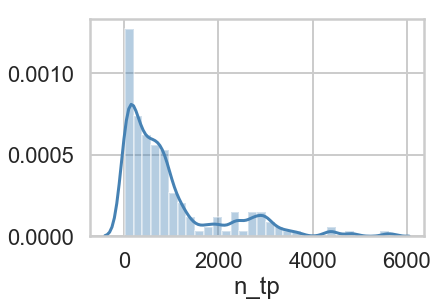

In [11]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [12]:
net_data.subj.nunique()

178

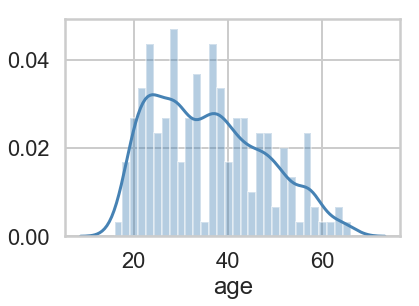

In [13]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

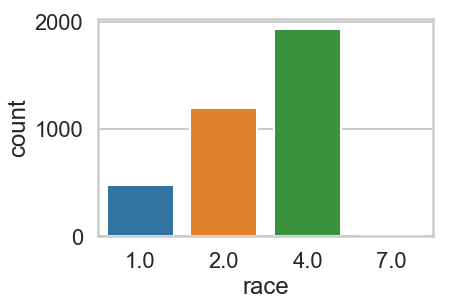

In [14]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

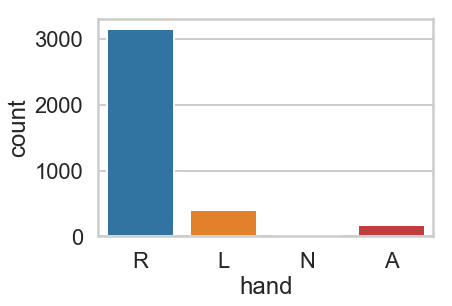

In [15]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

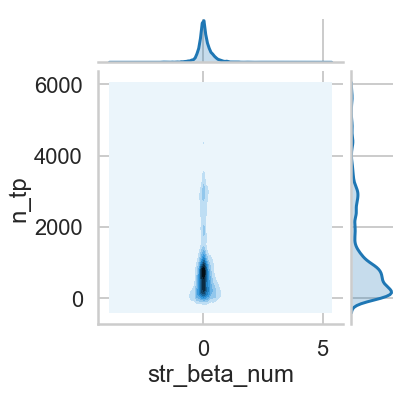

In [16]:
sns.jointplot(data=net_data, x='str_beta_num', y='n_tp', kind='kde' )

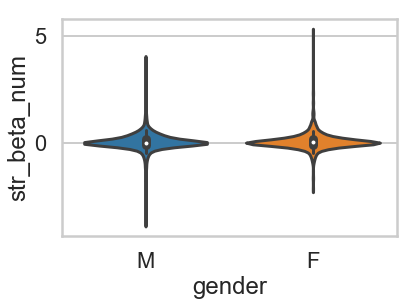

In [17]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [18]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [19]:
# check for duplicates, these two numbers should match
print(net_data.dropna().subj.nunique())
print(net_data[net_data.band_measure == 'theta_plv'].dropna().subj.count())

110
110


In [20]:
# some subjects have ambidextrous and right handed answers in demographics, 
# take the one that is used in the net data (whatever they said first)
dems = ['race', 'hand', 'gender', 'age']
subjs = node_data['subj'].unique()
for s in subjs:
    if any(node_data.loc[node_data['subj'] == s, dems].nunique() > 1):
        correct_dems = net_data.loc[net_data.subj == s, dems]
        node_data.loc[node_data['subj'] == s, dems] = np.tile(correct_dems.iloc[0,:].values, 
                                                              (sum(node_data['subj'] == s),1))
node_data.drop(index=node_data.index[node_data.duplicated()], inplace=True)
node_data.dropna(axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141319 entries, 1 to 397792
Data columns (total 27 columns):
elec                      141319 non-null object
band_measure              141319 non-null object
n_tp                      141319 non-null int64
elec_spike                141319 non-null float64
elec_in_soz               141319 non-null int64
str_soz_beta_bin          141319 non-null float64
str_not_soz_beta_bin      141319 non-null float64
str_spike_beta_bin        141319 non-null float64
str_not_spike_beta_bin    141319 non-null float64
str_beta_bin              141319 non-null float64
str_soz_beta_num          141319 non-null float64
str_not_soz_beta_num      141319 non-null float64
str_spike_beta_num        141319 non-null float64
str_beta_num              141319 non-null float64
str_not_spike_beta_num    141319 non-null float64
fc_measure                141319 non-null object
band                      141319 non-null object
region                    141319 non-null objec

In [21]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

## Effects on Network Measures

visualize how much spikes regularly change network strength.

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


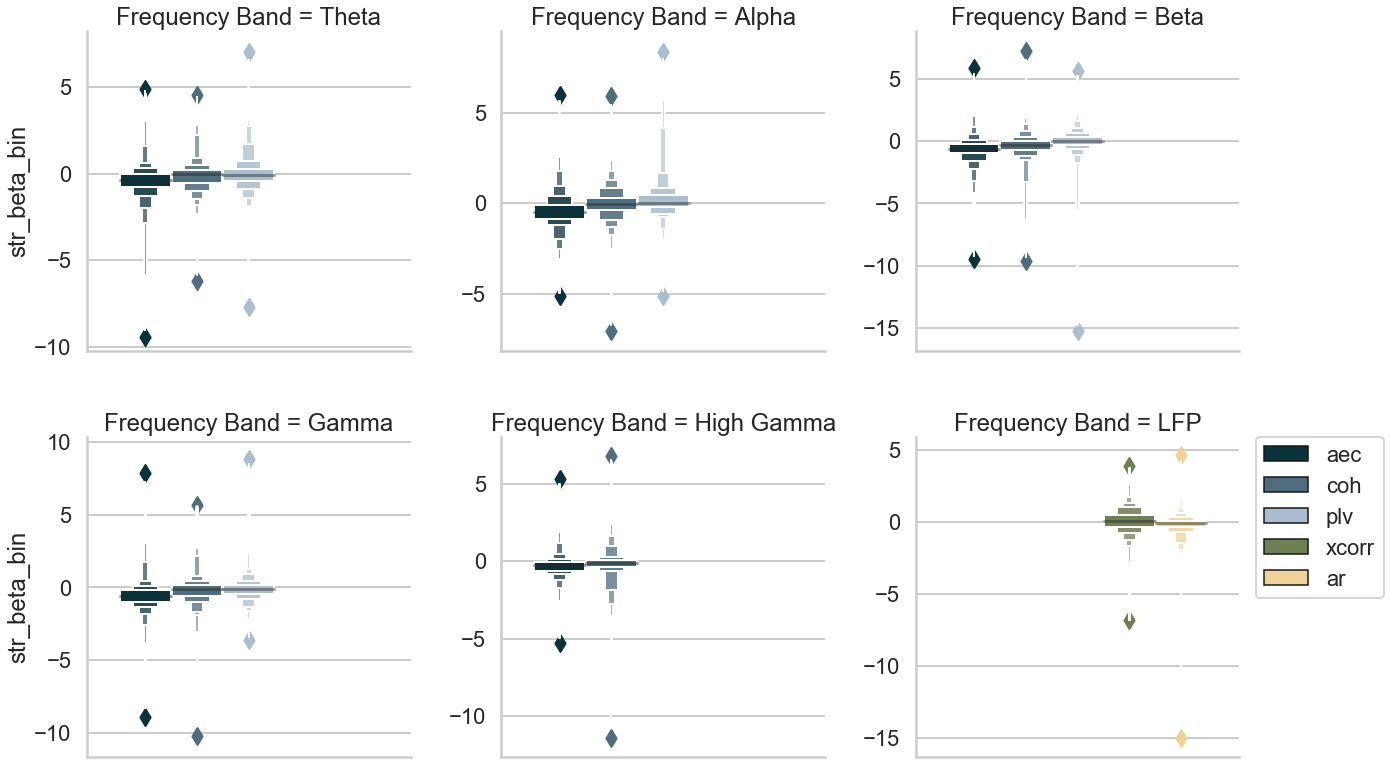

In [105]:

# rename stuff so it looks prettier - do the rest in illustrator
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha', 'beta':'Beta', 'gamma':'Gamma', 
                              'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)

# parameters
supp_flag = False # if true, includes orthogonal AEC
yvar = 'bin'

if (not supp_flag):
    h_order = ['aec', 'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#023743', '#476f84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'aec', 'coh', 'plv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#453947', '#023743',  '#476F84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
# a different way of plotting where everything is on the same axis
#plt.figure(figsize=(20,10))
#sns.boxenplot( data=net_data, x="Frequency Band", y='str_beta_' + yvar, hue='Measure', 
#            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
    
g.savefig(f"../img/net_{yvar}_str{detector}.eps")



Is this because of volume conduction?

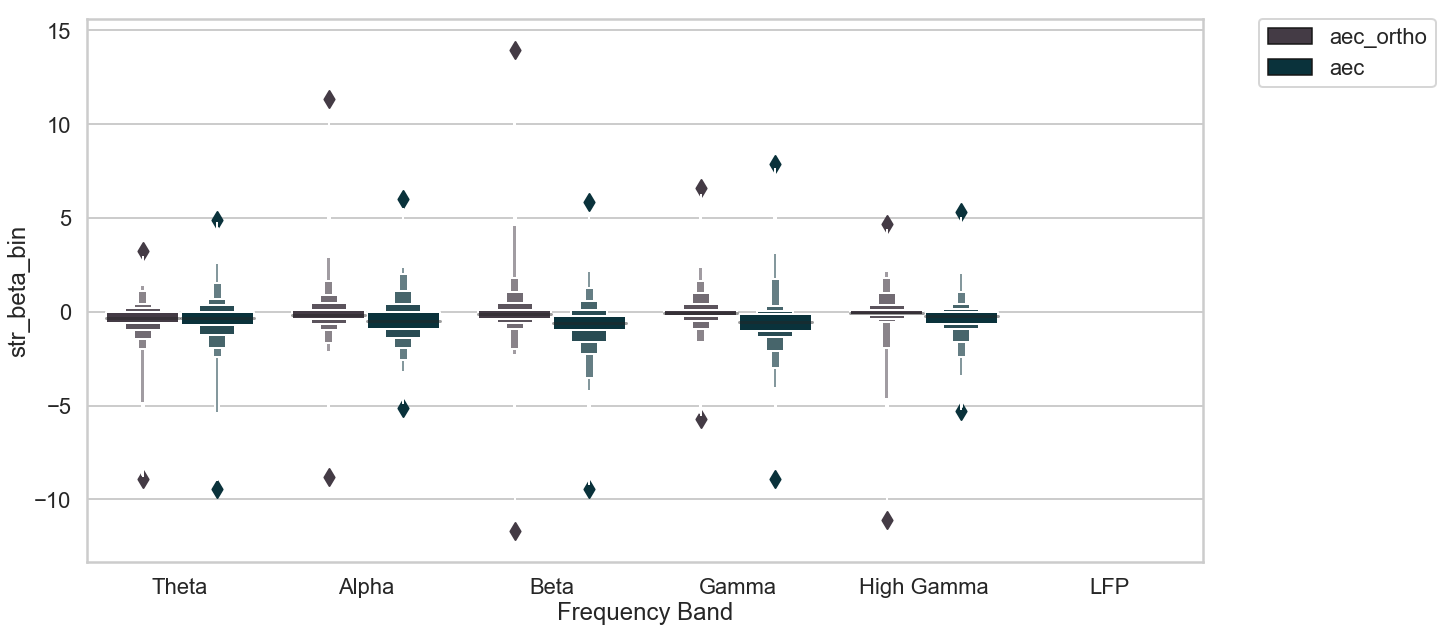

In [185]:

# parameters
y_var = 'bin'

h_order = ['aec_ortho', 'aec']
# color pallette
colors = ['#453947', '#023743']
custom_palette = sns.set_palette(sns.color_palette(colors))

sns.boxenplot( data=net_data[(net_data['Measure'] == 'aec') | (net_data['Measure'] == 'aec_ortho')]
              , x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/volume_conduction_{y_var}{detector}.eps")


Is it different within or outside of the SOZ?

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


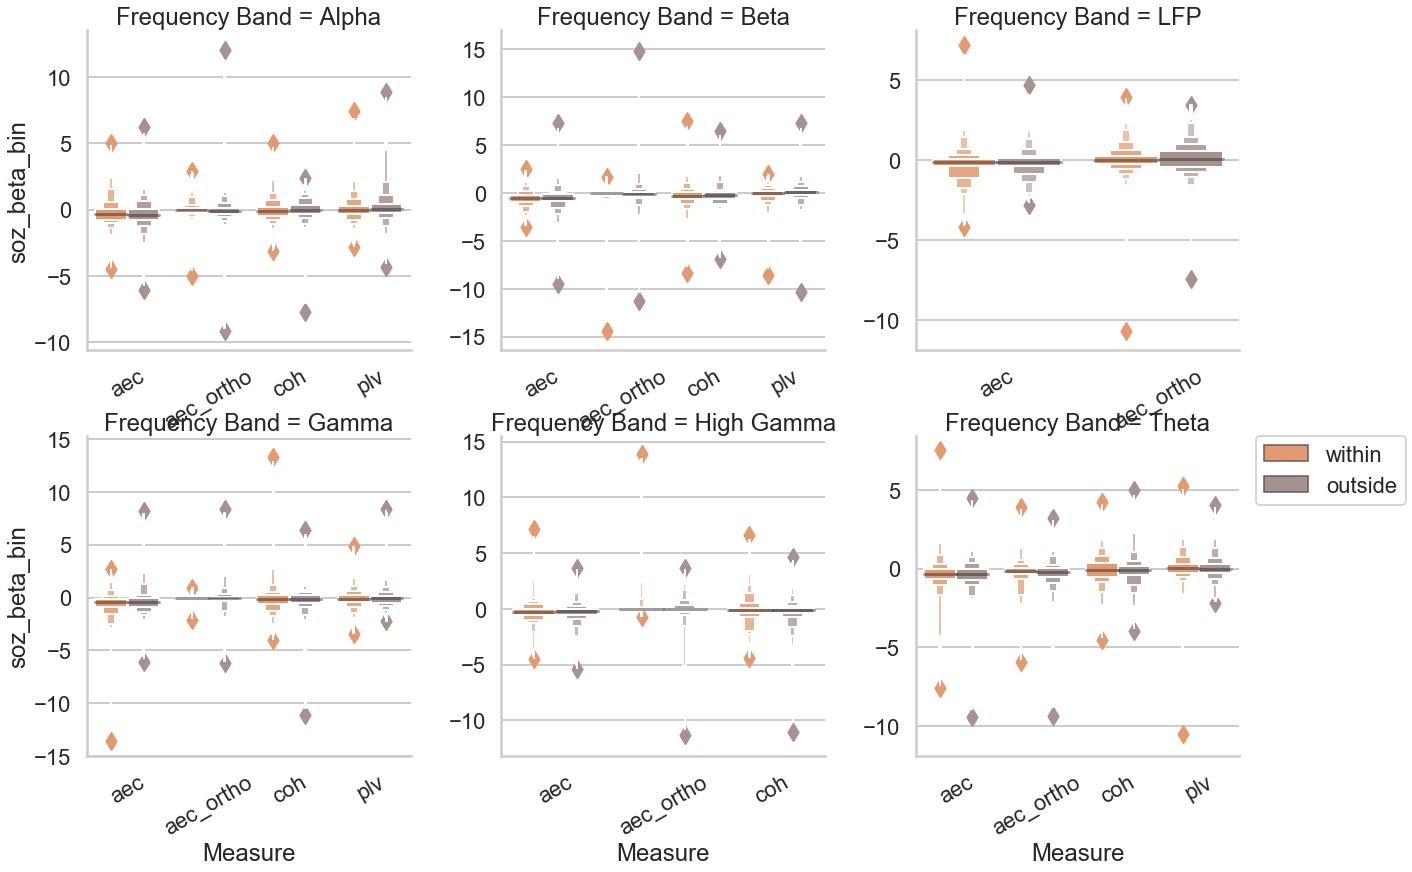

In [186]:
yvar = 'bin'

# reshape data
soz_data = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                           value_vars =['str_soz_beta_' + yvar,'str_not_soz_beta_' + yvar],  
                           var_name ='SOZ', value_name ='soz_beta_' + yvar)  
soz_data['SOZ'].replace(['str_soz_beta_' + yvar, 'str_not_soz_beta_' + yvar], ['within', 'outside'], inplace=True)
#color pallette
colors = ['#F6955E', '#A98F8E']
    
g = sns.FacetGrid(data=soz_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'soz_beta_' + yvar, 'SOZ', palette = sns.color_palette(colors), 
      hue_order=['within','outside'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
    

if yvar == 'num':
    soz_num = soz_data
else:
    soz_bin = soz_data


In [88]:
# add difference for plotting
net_data = net_data.assign(soz_diff_num = net_data['str_soz_beta_num'] - net_data['str_not_soz_beta_num'], 
                           soz_diff_bin = net_data['str_soz_beta_bin'] - net_data['str_not_soz_beta_bin'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


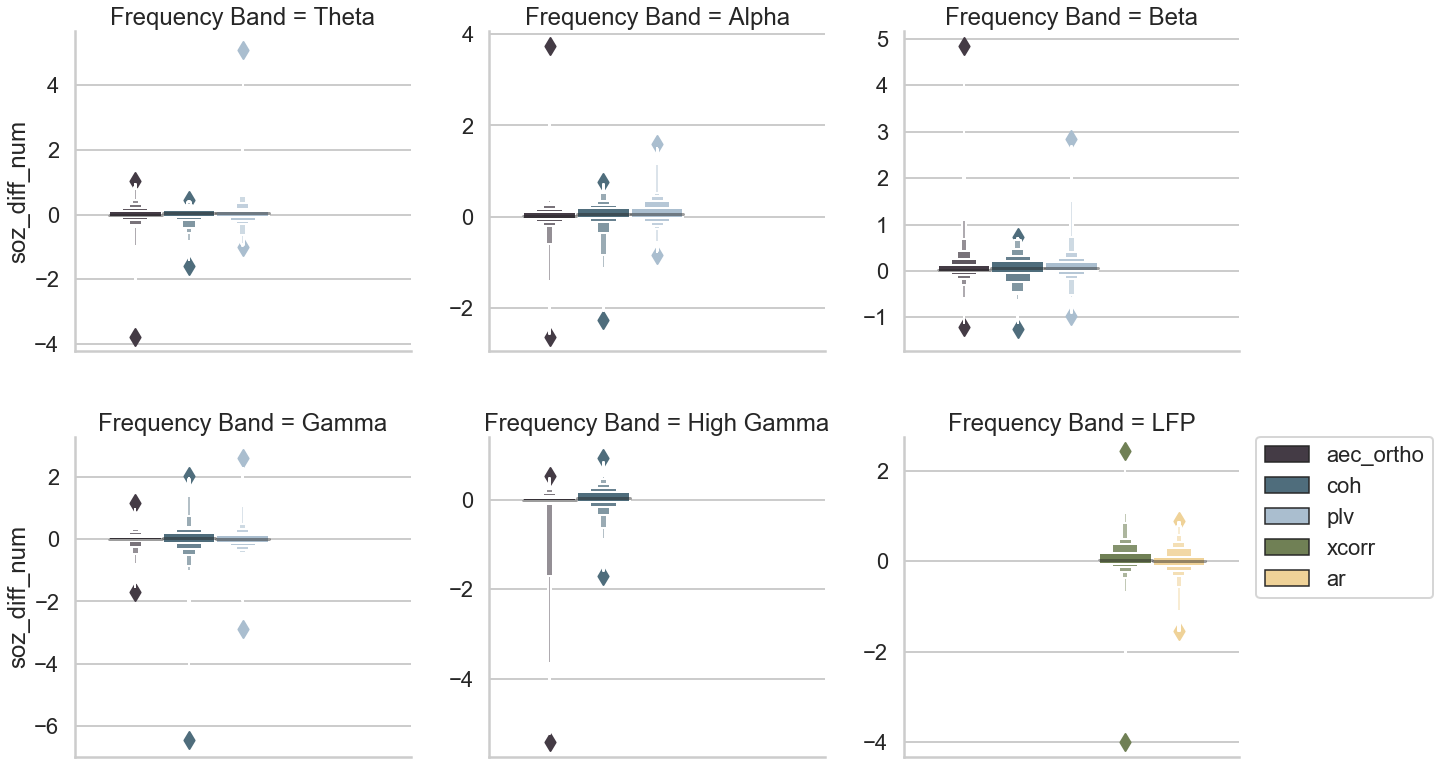

In [109]:
yvar = 'num'

colors = ['#453947', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'coh', 'plv', 'xcorr', 'ar']

g = sns.FacetGrid(data=net_data, col='Frequency Band', col_wrap=3, sharex=False, sharey=False, height=6,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, "Frequency Band", "soz_diff_" + yvar, "Measure",
             hue_order = h_order,  palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)

g.savefig(f"../img/net_soz_{yvar}{detector}.eps")

In [189]:
# save
soz_net_data = pd.merge(soz_bin, soz_num, on=['Frequency Band', 'Measure', 'subj', 'SOZ', 'hand','race','gender','age'])
soz_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


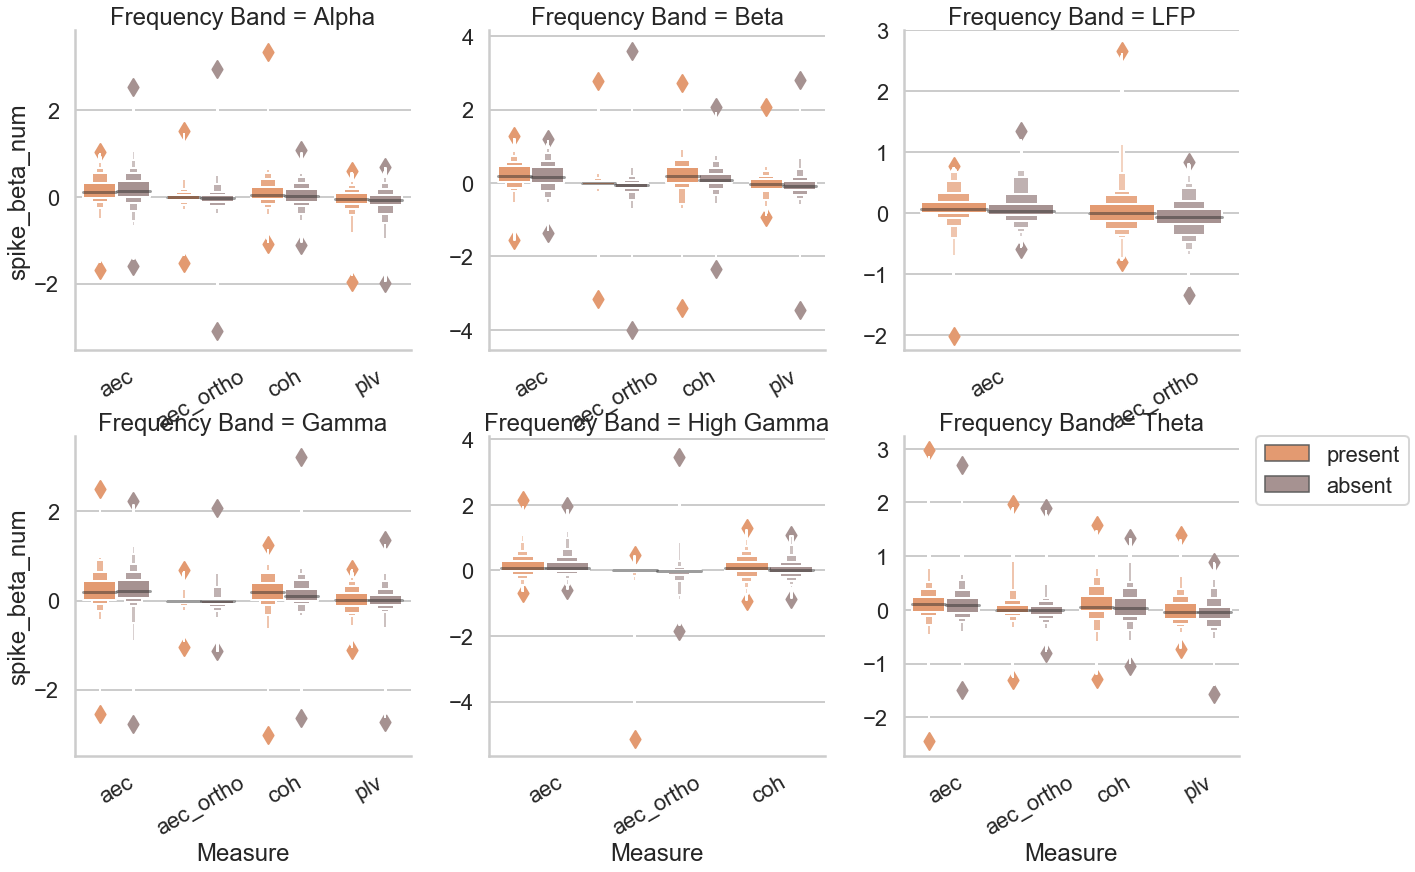

In [190]:
yvar = 'num'

# reshape data
spike_data = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                           value_vars =['str_spike_beta_' + yvar,'str_not_spike_beta_' + yvar],  
                           var_name ='spike', value_name ='spike_beta_' + yvar)  
spike_data['spike'].replace(['str_spike_beta_' + yvar, 'str_not_spike_beta_' + yvar], ['present', 'absent'], inplace=True)
#color pallette
colors = ['#F6955E', '#A98F8E']
    
g = sns.FacetGrid(data=spike_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'spike_beta_' + yvar, 'spike', palette = sns.color_palette(colors), 
      hue_order=['present','absent'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
    
if yvar == 'num':
    spike_num = spike_data
else:
    spike_bin = spike_data


In [99]:
# add difference for plotting
net_data = net_data.assign(spike_diff_num = net_data['str_spike_beta_num'] - net_data['str_not_spike_beta_num'], 
                           spike_diff_bin = net_data['str_spike_beta_bin'] - net_data['str_not_spike_beta_bin'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


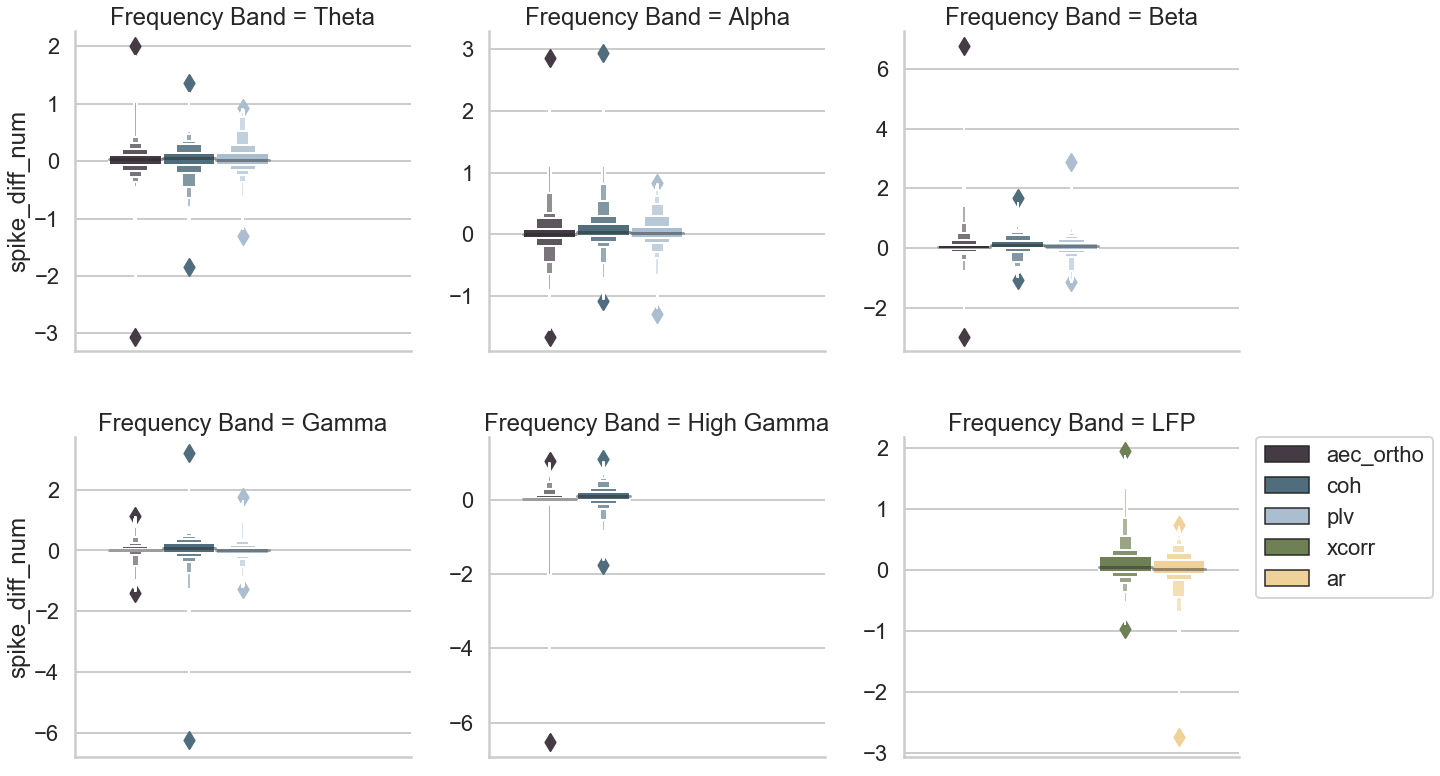

In [112]:
yvar = 'num'

colors = ['#453947', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'coh', 'plv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "spike_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/net_spike_{yvar}{detector}.eps")

In [193]:
# save
spike_net_data = pd.merge(spike_bin, spike_num, on=['Frequency Band', 'Measure', 'subj', 'spike', 'hand','race','gender','age'])
spike_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

## Which explains more variance? Coverage, or individual?

In [23]:
# get correlation matrix for all str effects
# thi subj has duplicates...unclear why
node_data = node_data[node_data['subj'] != 'R1232N']
sim_data = node_data[['subj', 'region', 'str_beta_bin', 'str_beta_num', 'band_measure']]
sim_data = sim_data.assign(unique_id = sim_data['subj'] + '_' + sim_data['region'], 
                           reg_id = sim_data['region'] + '_' + sim_data['subj'])
subj_data = sim_data.pivot_table(index = 'unique_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num']) # default agg func is mean
subj_data.head()

str_beta_bin                                      \
band_measure               alpha_aec alpha_aec_ortho alpha_coh alpha_plv   
unique_id                                                                  
R1001P_fusiform             0.047989       -0.001969  0.116477  0.064843   
R1001P_inferiortemporal    -0.117190       -0.006814  0.084597 -0.041423   
R1001P_lateraloccipital    -0.193000       -0.004700  0.236389  0.104319   
R1001P_lingual             -0.076008       -0.003474  0.162889  0.049067   
R1001P_middletemporal      -0.174446        0.002243  0.065737  0.069563   

                                                                      \
band_measure             beta_aec beta_aec_ortho  beta_coh  beta_plv   
unique_id                                                              
R1001P_fusiform         -0.213095       0.000302 -0.032015 -0.020874   
R1001P_inferiortemporal -0.172614      -0.001548  0.128849  0.052919   
R1001P_lateraloccipital -0.328138      -0.001752  0.059280  0.084547   
R1001P_lingual          -0.128282       0.000470  0.235316  0.113932   
R1001P_middletemporal   -0.108570      -0.001329 -0.106800  0.091273   

                                                        ...     \
band_measure            broadband_ar broadband_xcorr    ...      
unique_id                                               ...      
R1001P_fusiform             0.004601        0.279367    ...      
R1001P_inferiortemporal     0.023521        0.328754    ...      
R1001P_lateraloccipital     0.028825        0.184986    ...      
R1001P_lingual              0.021509        0.346520    ...      
R1001P_middletemporal       0.039443        0.349368    ...      

                           str_beta_num                                \
band_measure            gamma_aec_ortho gamma_coh gamma_plv    hg_aec   
unique_id                                                               
R1001P_fusiform                0.000061 -0.011502 -0.005028  0.009761   
R1001P_inferiortemporal       -0.000034  0.009902 -0.014448  0.012741   
R1001P_lateraloccipital       -0.000078  0.027542  0.008394  0.013173   
R1001P_lingual                 0.000043  0.015658 -0.010294 -0.034190   
R1001P_middletemporal          0.000095 -0.001459  0.029377  0.017861   

                                                                          \
band_measure            hg_aec_ortho    hg_coh theta_aec theta_aec_ortho   
unique_id                                                                  
R1001P_fusiform            -0.000009 -0.005795  0.042193       -0.003326   
R1001P_inferiortemporal    -0.000014  0.030200  0.014487       -0.013538   
R1001P_lateraloccipital    -0.000025  0.009163  0.005682        0.007567   
R1001P_lingual              0.000018  0.050679 -0.006008        0.011250   
R1001P_middletemporal       0.000015  0.016850 -0.000289        0.001982   

                                             
band_measure            theta_coh theta_plv  
unique_id                                    
R1001P_fusiform          0.002174  0.003716  
R1001P_inferiortemporal  0.007185 -0.042675  
R1001P_lateraloccipital -0.015855 -0.001712  
R1001P_lingual           0.051744  0.000200  
R1001P_middletemporal    0.041262  0.003767  

[5 rows x 42 columns]

In [24]:
# get correlation matrix for all str effects
reg_data = sim_data.pivot_table(index = 'reg_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num']) # default agg func is mean
reg_data.head()

str_beta_bin                                                \
band_measure       alpha_aec alpha_aec_ortho alpha_coh alpha_plv  beta_aec   
reg_id                                                                       
bankssts_R1008J    -0.605947        0.006764 -0.550321 -0.137149 -0.541359   
bankssts_R1009W    -0.871009        0.007601  0.375139 -0.196495  0.633843   
bankssts_R1014D     0.432329        0.009630  1.289233  0.287680  0.388816   
bankssts_R1015J    -0.005631        0.017523  0.147200  0.159968 -0.111734   
bankssts_R1018P    -1.980115        0.210688  1.793185  2.663156  0.578112   

                                                                 \
band_measure    beta_aec_ortho  beta_coh  beta_plv broadband_ar   
reg_id                                                            
bankssts_R1008J      -0.003079 -0.231815 -0.073163    -0.257660   
bankssts_R1009W      -0.002712  0.608152  1.032841    -0.149390   
bankssts_R1014D       0.013649 -0.205244 -0.196499    -0.580140   
bankssts_R1015J       0.000081  0.000480  0.207362    -0.255121   
bankssts_R1018P       0.022915  0.625316 -1.251089    -0.080547   

                                   ...       str_beta_num                      \
band_measure    broadband_xcorr    ...    gamma_aec_ortho gamma_coh gamma_plv   
reg_id                             ...                                          
bankssts_R1008J        0.370097    ...           0.000262  0.206778  0.148545   
bankssts_R1009W        0.515790    ...           0.000695  0.095567  0.022510   
bankssts_R1014D       -0.123753    ...           0.000687 -0.018344  0.352863   
bankssts_R1015J        0.836488    ...           0.000093  0.108793 -0.012404   
bankssts_R1018P        1.724841    ...          -0.004882 -0.102325 -0.231588   

                                                                            \
band_measure       hg_aec hg_aec_ortho    hg_coh theta_aec theta_aec_ortho   
reg_id                                                                       
bankssts_R1008J -0.081021    -0.000273  0.152299  0.091772        0.067263   
bankssts_R1009W  0.232758    -0.002164  0.058050  0.323400       -0.010346   
bankssts_R1014D  0.249345     0.000206 -0.170699  0.269739        0.013703   
bankssts_R1015J  0.029867    -0.000135  0.055402  0.022285       -0.027233   
bankssts_R1018P -0.008354    -0.000002 -0.057513  0.141113        0.034036   

                                     
band_measure    theta_coh theta_plv  
reg_id                               
bankssts_R1008J  0.259752 -0.007283  
bankssts_R1009W  0.394888 -0.027110  
bankssts_R1014D -0.404718 -0.068376  
bankssts_R1015J  0.059544 -0.094986  
bankssts_R1018P  0.103033  0.079300  

[5 rows x 42 columns]

In [25]:
# ordered by subj corr map
corr = subj_data.T.corr()
reg_corr = reg_data.T.corr()

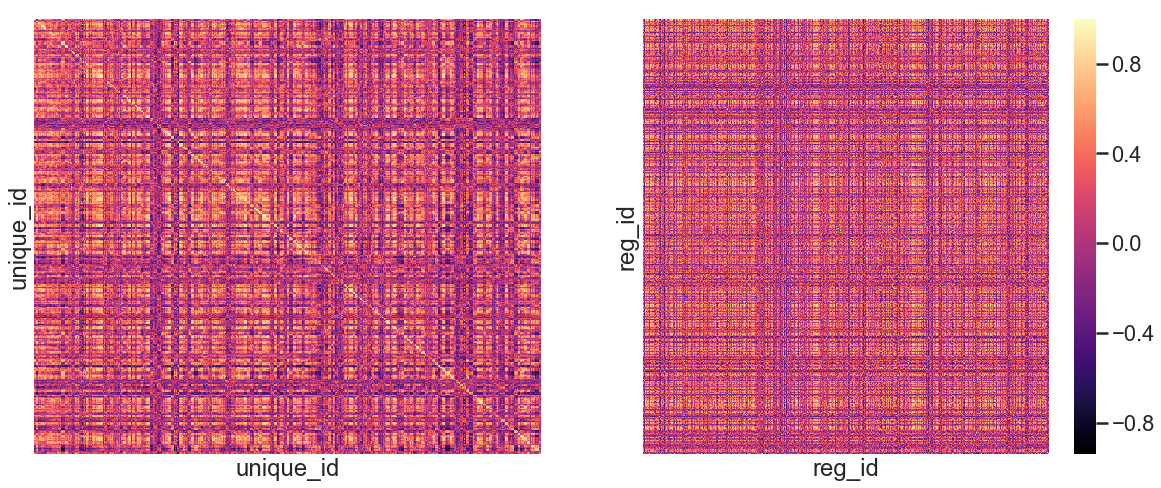

In [26]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(corr, xticklabels=False, yticklabels=False, cmap = 'magma',  cbar=False, ax=axes[0])
sns.heatmap(reg_corr, xticklabels=False, yticklabels=False, cmap='magma', cbar=True, ax=axes[1])

In [27]:
# get distributions for each group
subj_corrs = []
btwn_subj = []
reg_corrs = []
btwn_reg = []
label = []
for s in sim_data.subj.unique():
    idx = corr.index.str.contains(s)
    curr = corr.values[:,idx]
    btwn_curr = curr[~idx,:]
    curr = curr[idx,:]
    subj_corrs.append(np.nanmean(curr))
    btwn_subj.append(np.nanmean(btwn_curr))
    label.append('subj')
    
for r in sim_data.region.unique():
        idx = corr.index.str.contains(str(r))
        if sum(idx) > 0:
            curr = corr.values[:,idx]
            btwn_curr = curr[~idx,:]
            curr = curr[idx,:]
            reg_corrs.append(np.nanmean(curr))
            btwn_reg.append(np.nanmean(btwn_curr))
            label.append('region')
            
subj_corrs.extend(reg_corrs)
btwn_subj.extend(btwn_reg)

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


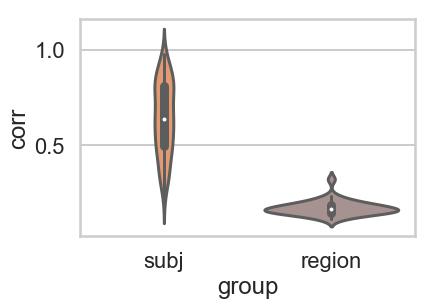

In [113]:
group_sim = pd.DataFrame({'corr':subj_corrs, 'btwn_corr':btwn_subj, 'group':label })
colors = ['#F6955E', '#A98F8E']
sns.violinplot(data=group_sim, x='group', y='corr', palette = sns.color_palette(colors))

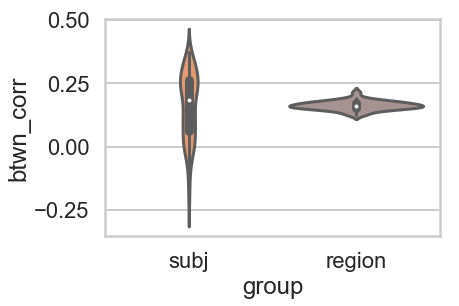

In [114]:
sns.violinplot(data=group_sim, x='group', y='btwn_corr', palette=sns.set_palette(colors))

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


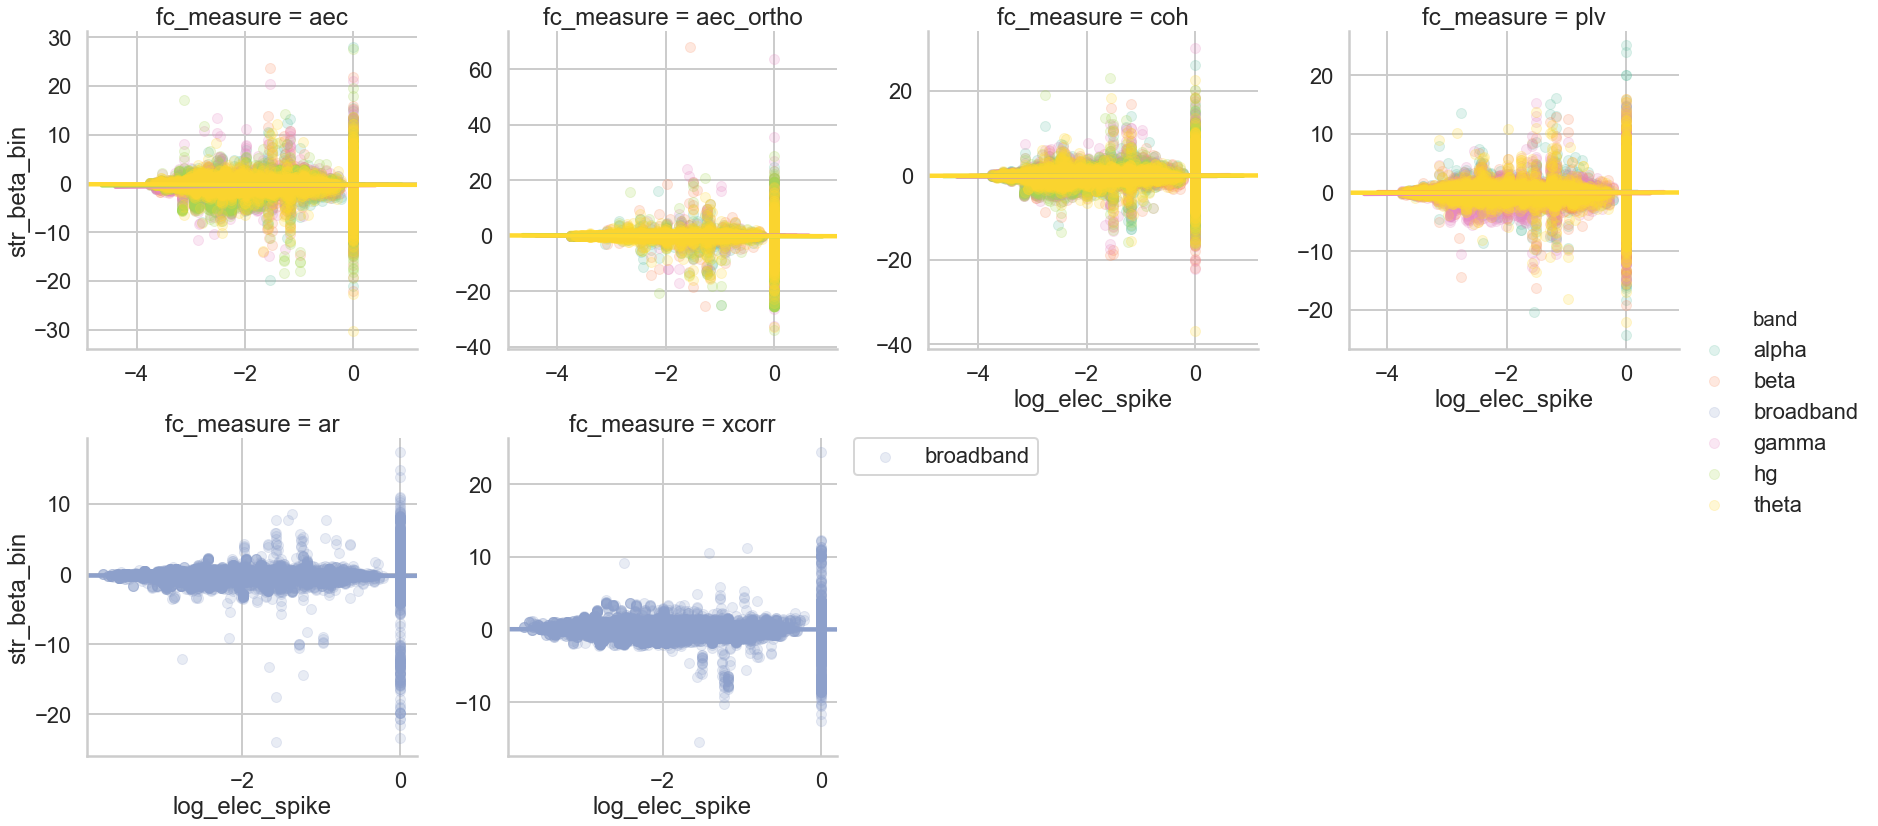

In [513]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

Total strength by type

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


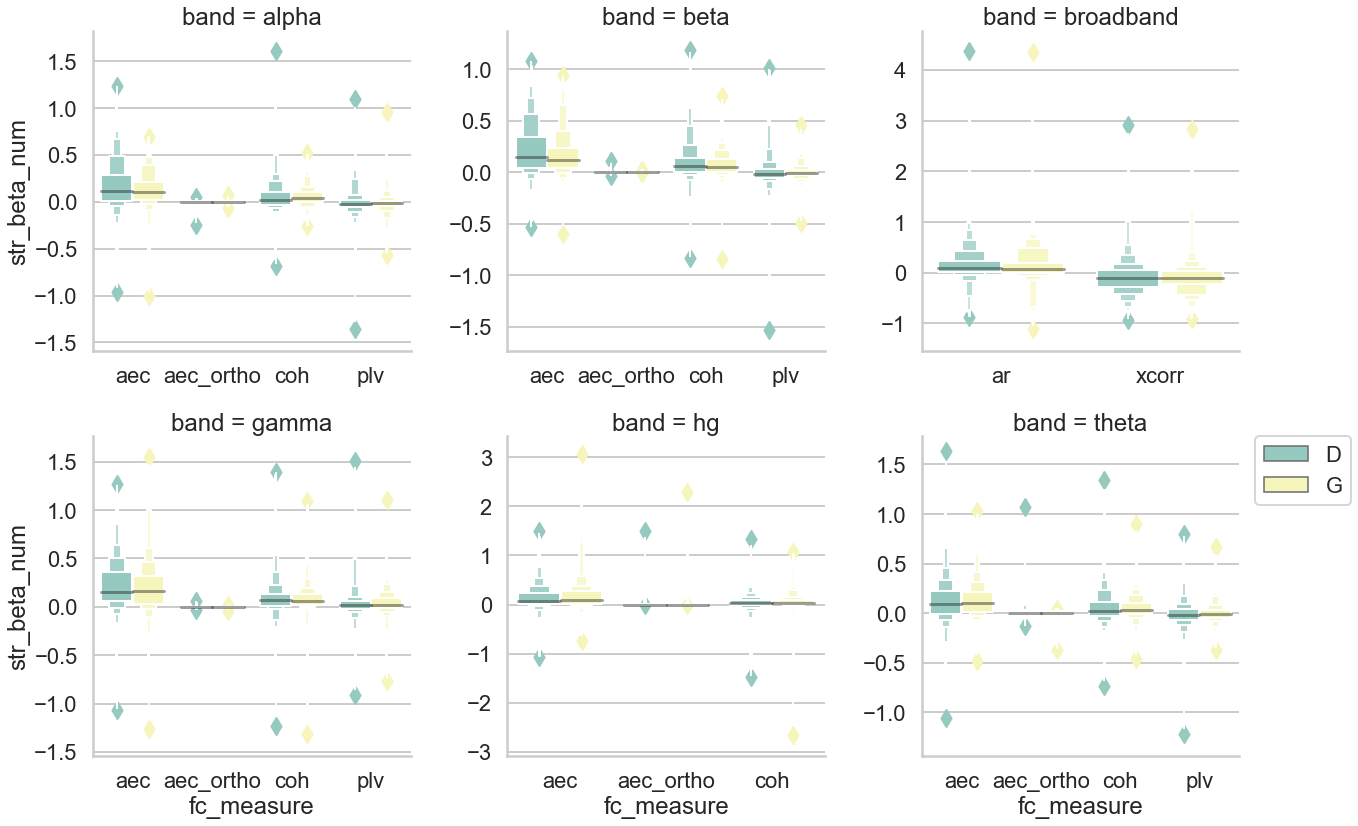

In [31]:
# strip is functionally the same as grid
node_data.loc[node_data.type == 'S','type'] = 'G'
type_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'type']).median().reset_index()

# grand teton natl park color pallette
colors = ['#a8d0cf', '#babbb1']
custom_palette = sns.set_palette(sns.color_palette(colors))
    
g = sns.FacetGrid(data=type_avg, col='band', col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, size=6)
g.map(sns.boxenplot, 'fc_measure', 'str_beta_num', 'type', palette = 'Set3', hue_order = ['D','G'])

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
type_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/type_stats{detector}.csv')

In [32]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys{detector}.csv', index_col=0)


In [33]:
# check number of contacts
# contacts that are really far away end up labelled as vis
sys['sys'].value_counts()

Vis            97140
Default         4647
Limbic          2391
SalVentAttn     1940
SomMot          1597
Cont            1416
DorsAttn        1320
Name: sys, dtype: int64

In [34]:
sys.groupby(['subj','sys']).min_d.mean().head(25)

subj    sys        
R1001P  Cont            13.462925
        Default         16.000491
        DorsAttn        12.306150
        Limbic          20.120398
        SalVentAttn     15.065420
        SomMot          13.164589
        Vis             14.353137
R1002P  Cont            14.499693
        Default         20.114818
        DorsAttn        16.196721
        Limbic          19.731470
        SalVentAttn     19.326486
        SomMot          13.525720
        Vis             16.885360
R1003P  Vis                   NaN
R1004D  Cont           120.370063
        Default        153.841812
        SalVentAttn    128.240812
R1006P  Vis                   NaN
R1008J  Default         15.089609
        DorsAttn        16.060019
        Limbic          16.926507
        SalVentAttn     16.998840
        Vis             15.265479
R1009W  Vis                   NaN
Name: min_d, dtype: float64

In [35]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798986 entries, 0 to 1798985
Data columns (total 31 columns):
elec                      object
band_measure              object
n_tp                      int64
elec_spike                float64
elec_in_soz               int64
str_soz_beta_bin          float64
str_not_soz_beta_bin      float64
str_spike_beta_bin        float64
str_not_spike_beta_bin    float64
str_beta_bin              float64
str_soz_beta_num          float64
str_not_soz_beta_num      float64
str_spike_beta_num        float64
str_beta_num              float64
str_not_spike_beta_num    float64
fc_measure                object
band                      object
region                    object
x                         float64
y                         float64
z                         float64
type                      object
subj                      object
hand                      object
age                       float64
gender                    object
race            

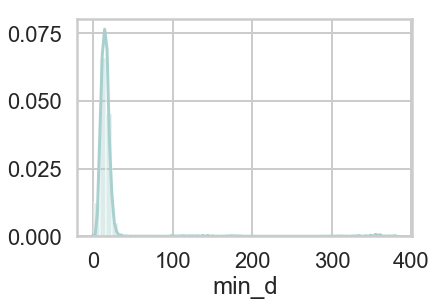

In [36]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(node_data['min_d'].dropna())

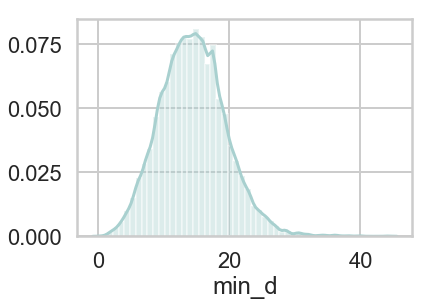

In [37]:
# get reid of contacts that clearly had poor match - greater than 2 std
node_data.loc[node_data['min_d'] > node_data['min_d'].mean() + node_data['min_d'].std(),['sys', 'parc', 'min_d', 'region']] = np.nan
sns.distplot(node_data['min_d'].dropna())

In [38]:
# get region -> system mapping to see if the MNI labels are any good
node_data.dropna(inplace=True, axis=0, subset=['min_d'])
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']].head()
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys
0  inferiorparietal  Default
1  inferiorparietal  Default
2  inferiorparietal  Default
3  inferiorparietal  Default
4  inferiorparietal  Default

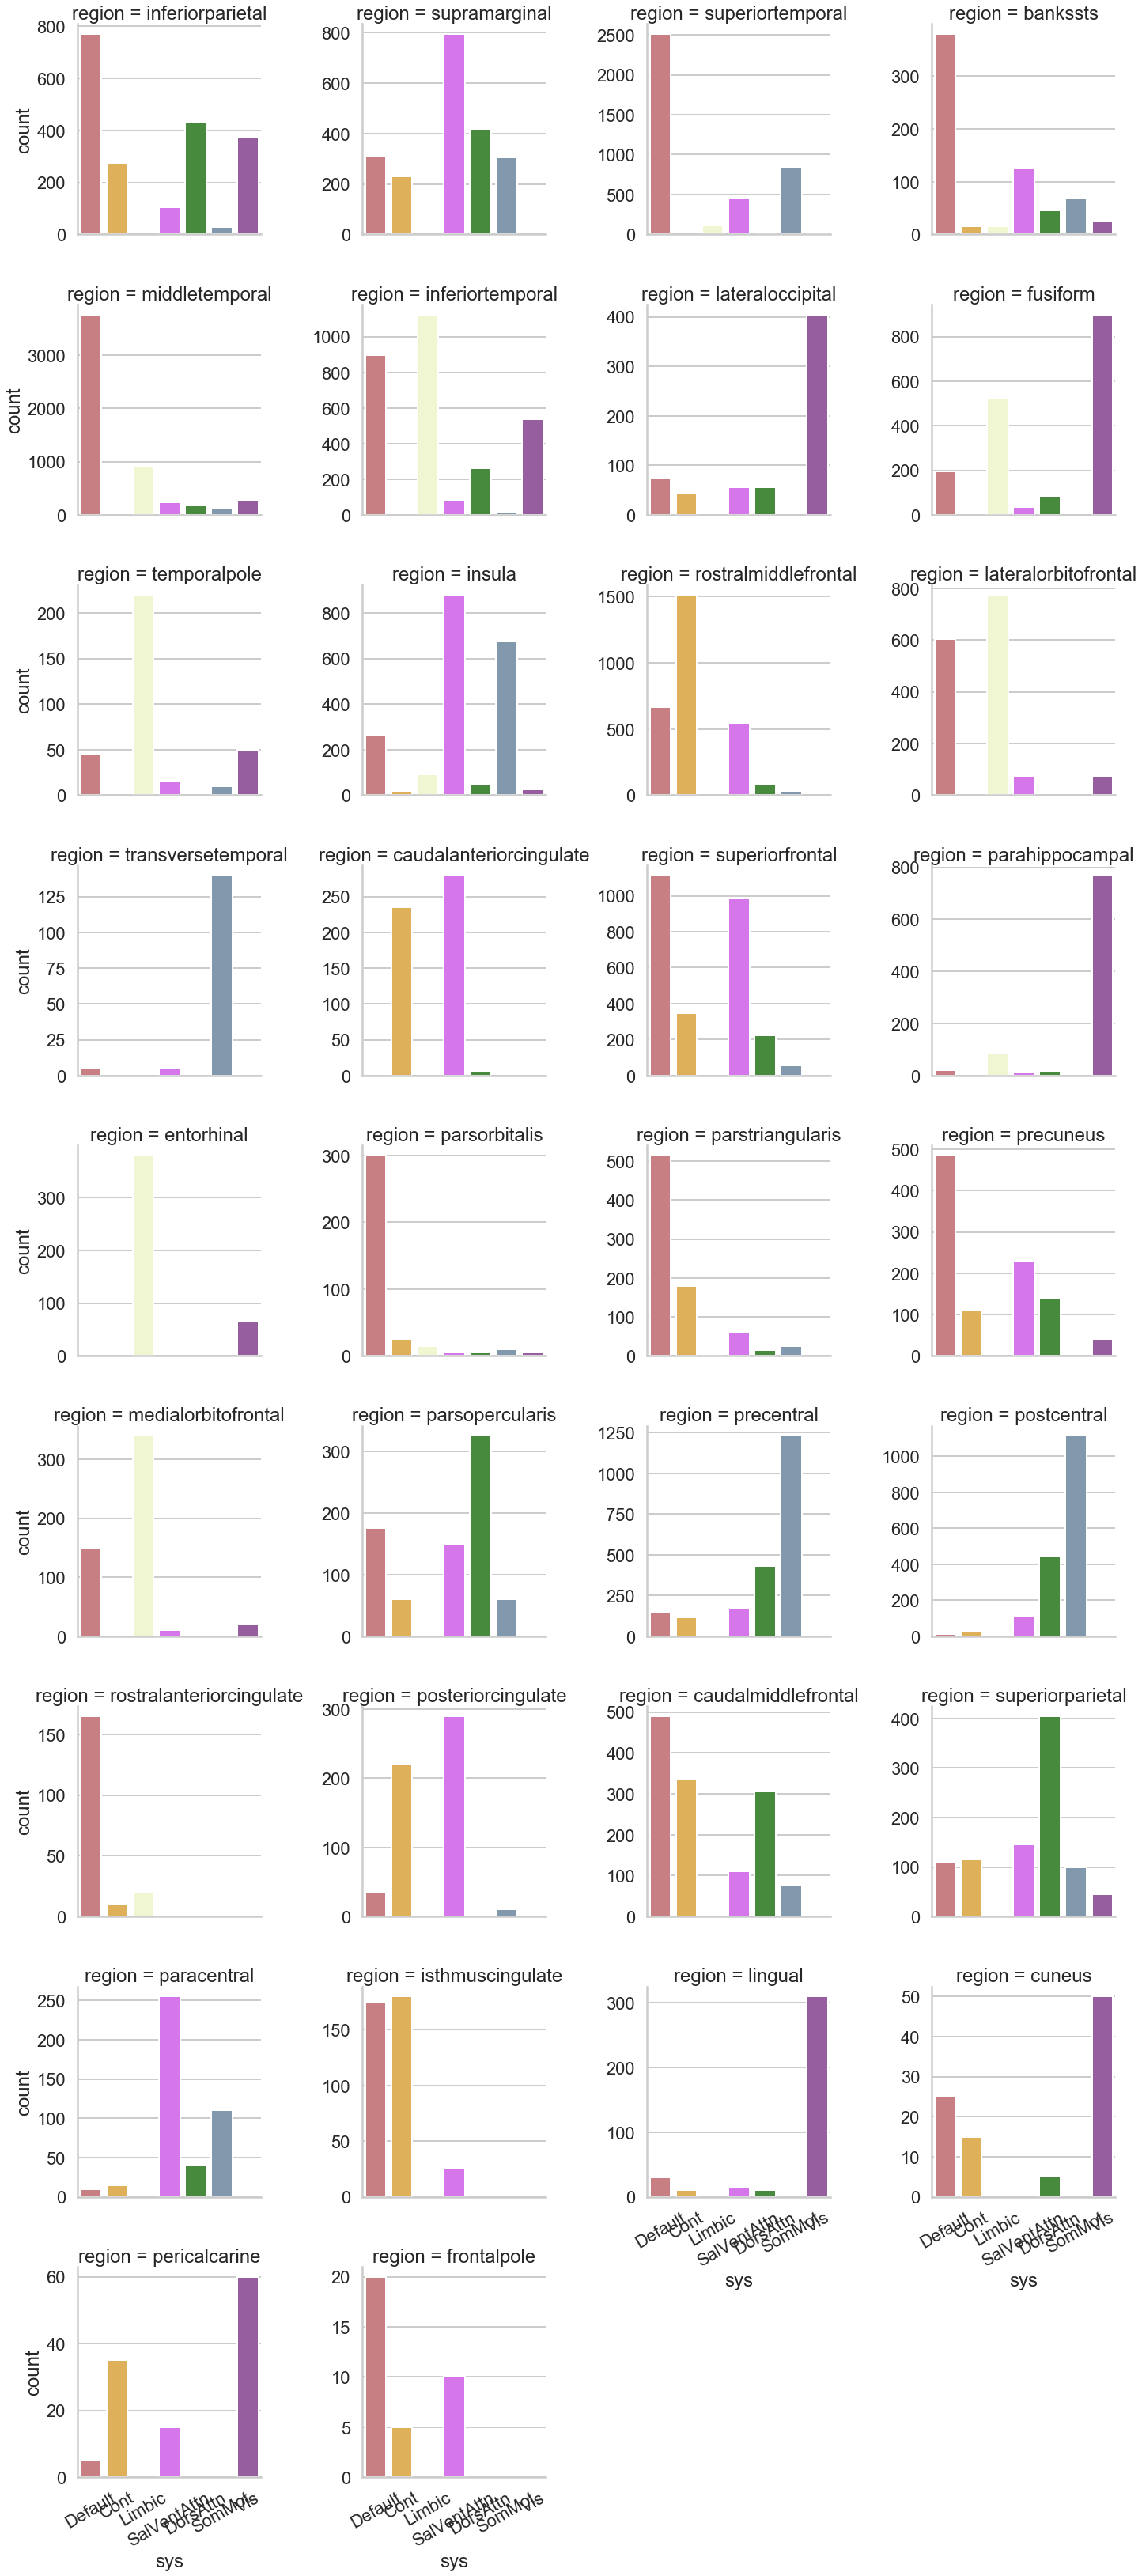

In [39]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
p = sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)
for a in p.axes:
    a.set_xticklabels(a.xaxis.get_majorticklabels(), rotation=30)
p.savefig(f'{RAM_dir}img/MNI_labels.png')

In [40]:
# z-score within subject
#node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_num', 'scale_bin'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


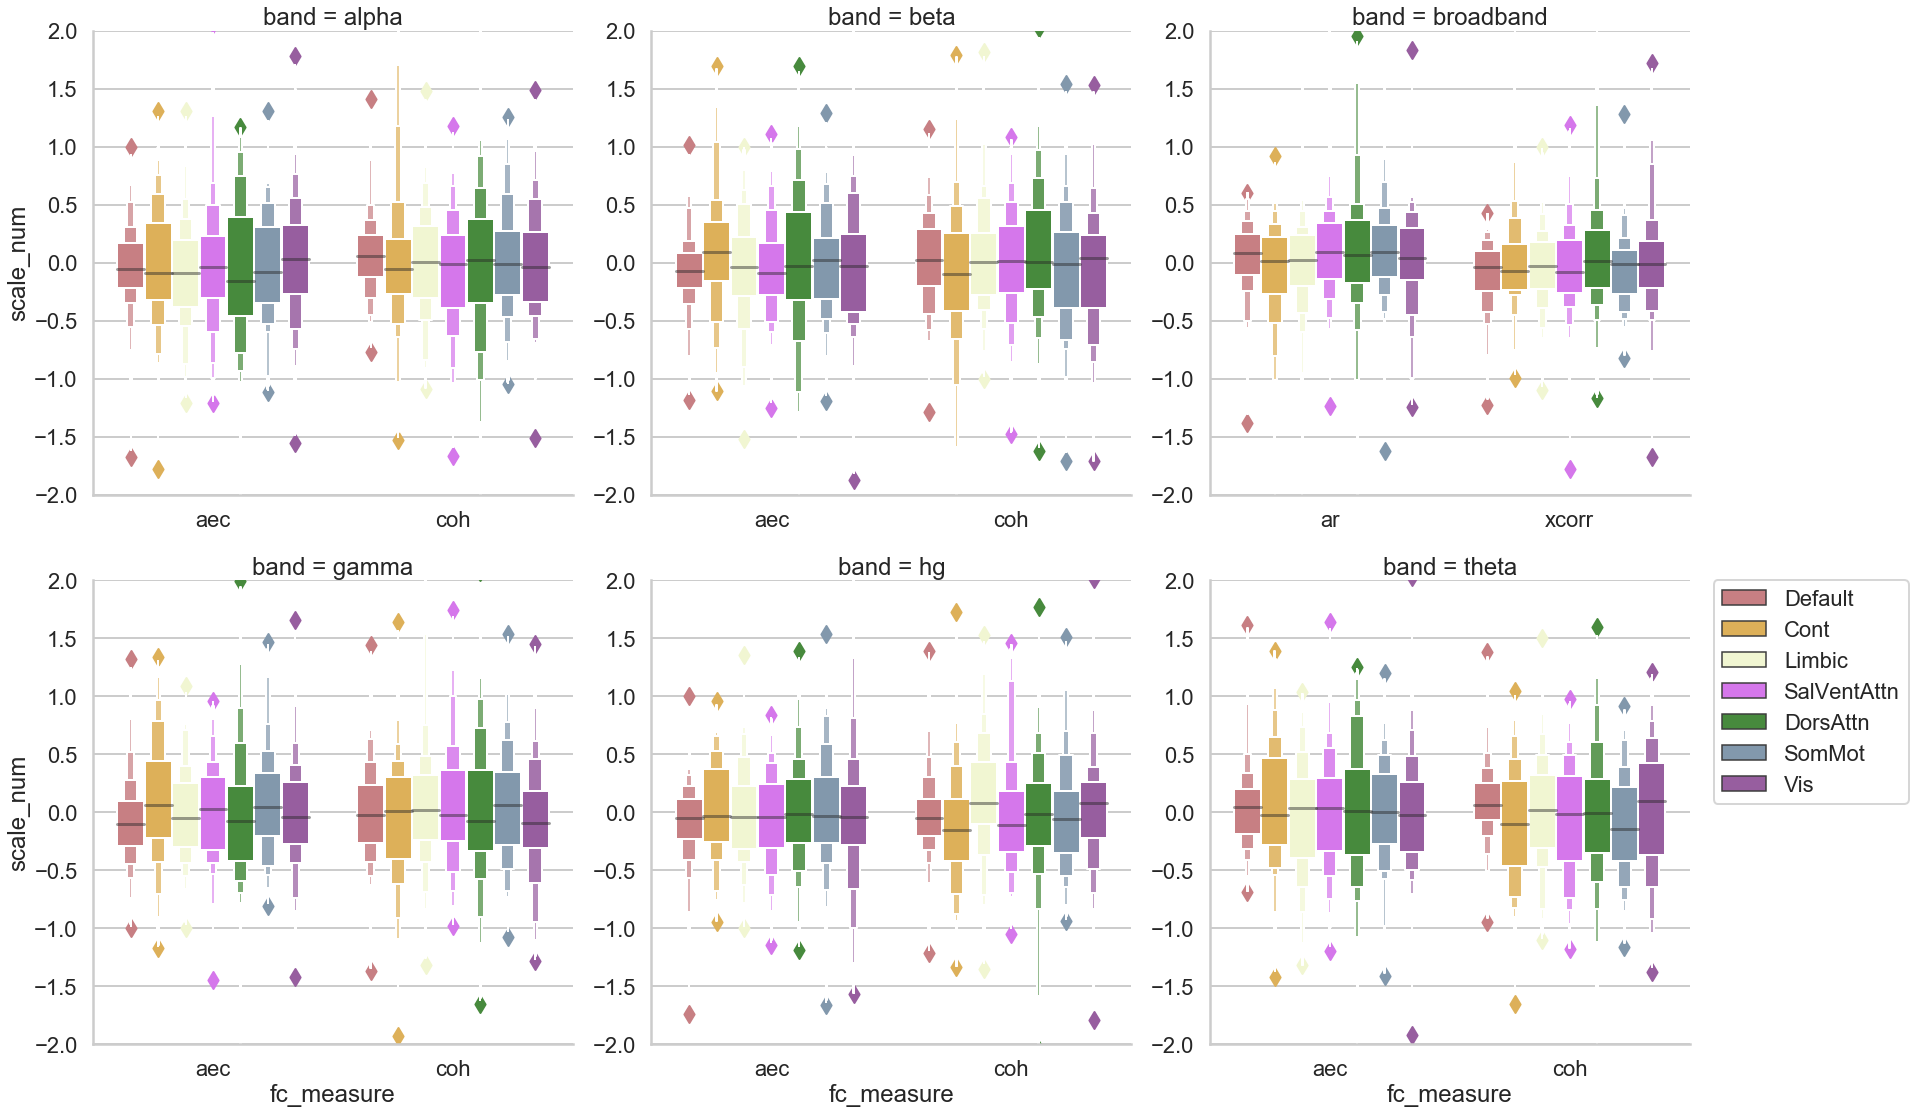

In [41]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec_ortho') & (sys_avg['fc_measure'] != 'plv')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_num', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.set_ylim(-2,2)
    
#g.savefig("../img/net_num.eps")

### Categorize SOZ

In [42]:
# check labels of elecs in soz for which sys they are in
flag = 'soz' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':node_data.subj.unique(), 
                                   'locus':np.empty(node_data.subj.unique().shape),
                                  'hem':np.empty(node_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] > 0] #curr[curr['elec_spike'] != 0]['elec_spike'].median()]
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0) | (any(curr.sys.isna())):
        epilepsy_type.loc[index, 'locus'] = np.nan
        epilepsy_type.loc[index,'hem'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
        epilepsy_type.loc[index, 'hem']= curr.hem.mode()[0]
    
epilepsy_type.head()           

subj     locus  hem
0  R1170J  DorsAttn   LH
1  R1284N       NaN  NaN
2  R1276D       NaN  NaN
3  R1263C       NaN  NaN
4  R1260D       NaN  NaN

In [43]:
epilepsy_type.dropna().subj.nunique()

79

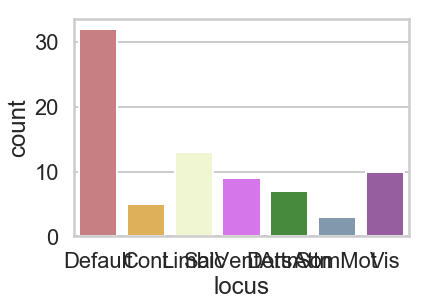

In [44]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

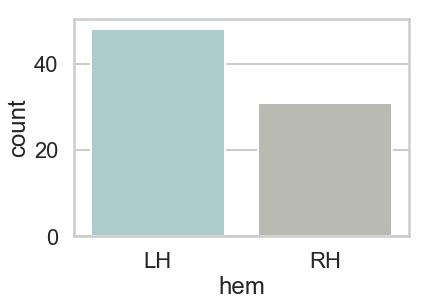

In [45]:
sns.countplot(data=epilepsy_type, x='hem')

In [46]:
# add locus back to big data frames
net_data = pd.merge(net_data, epilepsy_type, on='subj')
node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
0        alpha_aec   107      0.854233     -0.308418          1.059740   
1  alpha_aec_ortho   107      0.418842     -0.041771          0.139267   
2        alpha_coh   107      0.590071     -0.136139          1.332877   
3        alpha_plv   107      1.382341     -0.571861          0.567091   
4         beta_aec   107     -0.241167     -0.055265         -0.172447   

   str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
0         -0.420497             -0.270865           -0.142973   
1         -0.032859             -0.025390            0.200103   
2         -0.490406             -0.045080            0.038881   
3         -0.355160             -0.562533           -0.177097   
4         -0.067385             -0.053229            0.043149   

   str_not_soz_beta_bin  str_spike_beta_bin ...    Measure  \
0              0.792757            0.498661 ...        aec   
1              0.288357           -0.733798 ...  aec_ortho   
2              0.405967            0.215112 ...        coh   
3              1.409217            0.125400 ...        plv   
4             -0.215706           -0.657497 ...        aec   

  str_not_spike_beta_num  Frequency Band    subj hand   age  gender race  \
0              -0.329908           Alpha  R1170J    R  20.0       M  2.0   
1              -0.107114           Alpha  R1170J    R  20.0       M  2.0   
2              -0.156657           Alpha  R1170J    R  20.0       M  2.0   
3              -0.599338           Alpha  R1170J    R  20.0       M  2.0   
4              -0.079059            Beta  R1170J    R  20.0       M  2.0   

      locus hem  
0  DorsAttn  LH  
1  DorsAttn  LH  
2  DorsAttn  LH  
3  DorsAttn  LH  
4  DorsAttn  LH  

[5 rows x 21 columns]

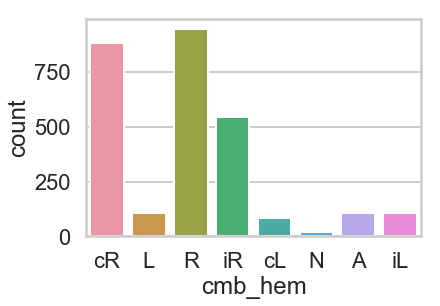

In [47]:
# add combined hand
ipsi = ((net_data['hand'] == 'L') & (net_data['hem'] == 'LH')) | ((net_data['hand'] == 'R') & (net_data['hem'] == 'RH'))
contra = ((net_data['hand'] == 'R') & (net_data['hem'] == 'LH')) | ((net_data['hand'] == 'L') & (net_data['hem'] == 'RH'))

hem_hand = np.empty(np.shape(ipsi), dtype=str)
hem_hand[ipsi] = 'ipsi'
hem_hand[contra] = 'contra'
net_data = net_data.assign(hem_hand=hem_hand)
net_data = net_data.assign(cmb_hem = net_data['hem_hand'] + net_data['hand'])
sns.countplot(net_data.cmb_hem)

In [48]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2793 entries, 0 to 2792
Data columns (total 23 columns):
band_measure              2793 non-null object
n_tp                      2793 non-null int64
str_beta_bin              2751 non-null float64
str_beta_num              2751 non-null float64
str_soz_beta_bin          2100 non-null float64
str_soz_beta_num          2100 non-null float64
str_not_soz_beta_num      2090 non-null float64
str_spike_beta_num        1953 non-null float64
str_not_soz_beta_bin      2090 non-null float64
str_spike_beta_bin        1953 non-null float64
str_not_spike_beta_bin    1943 non-null float64
Measure                   2793 non-null object
str_not_spike_beta_num    1943 non-null float64
Frequency Band            2793 non-null object
subj                      2793 non-null object
hand                      2793 non-null object
age                       2793 non-null float64
gender                    2793 non-null object
race                      2793 non-nu

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


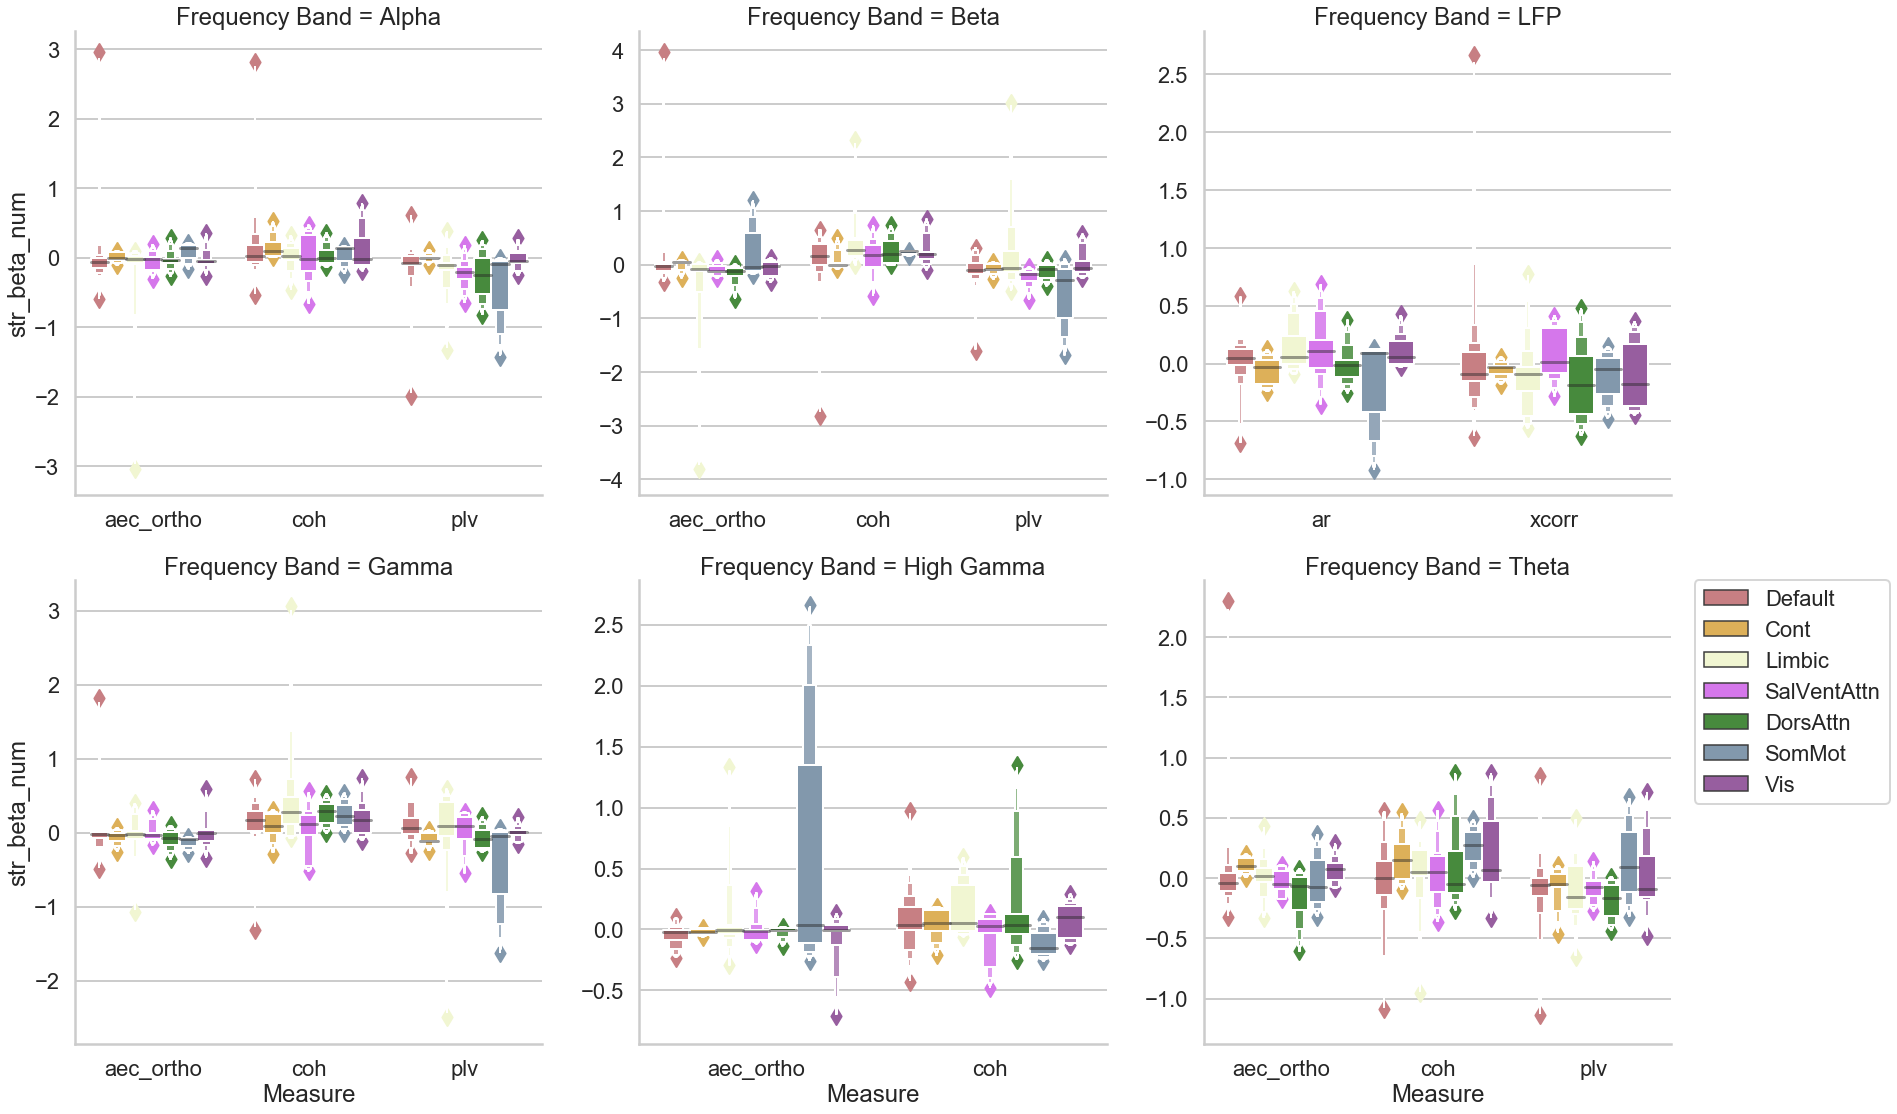

In [50]:
g = sns.FacetGrid(data=net_data[net_data.Measure != 'aec'], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_num', 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


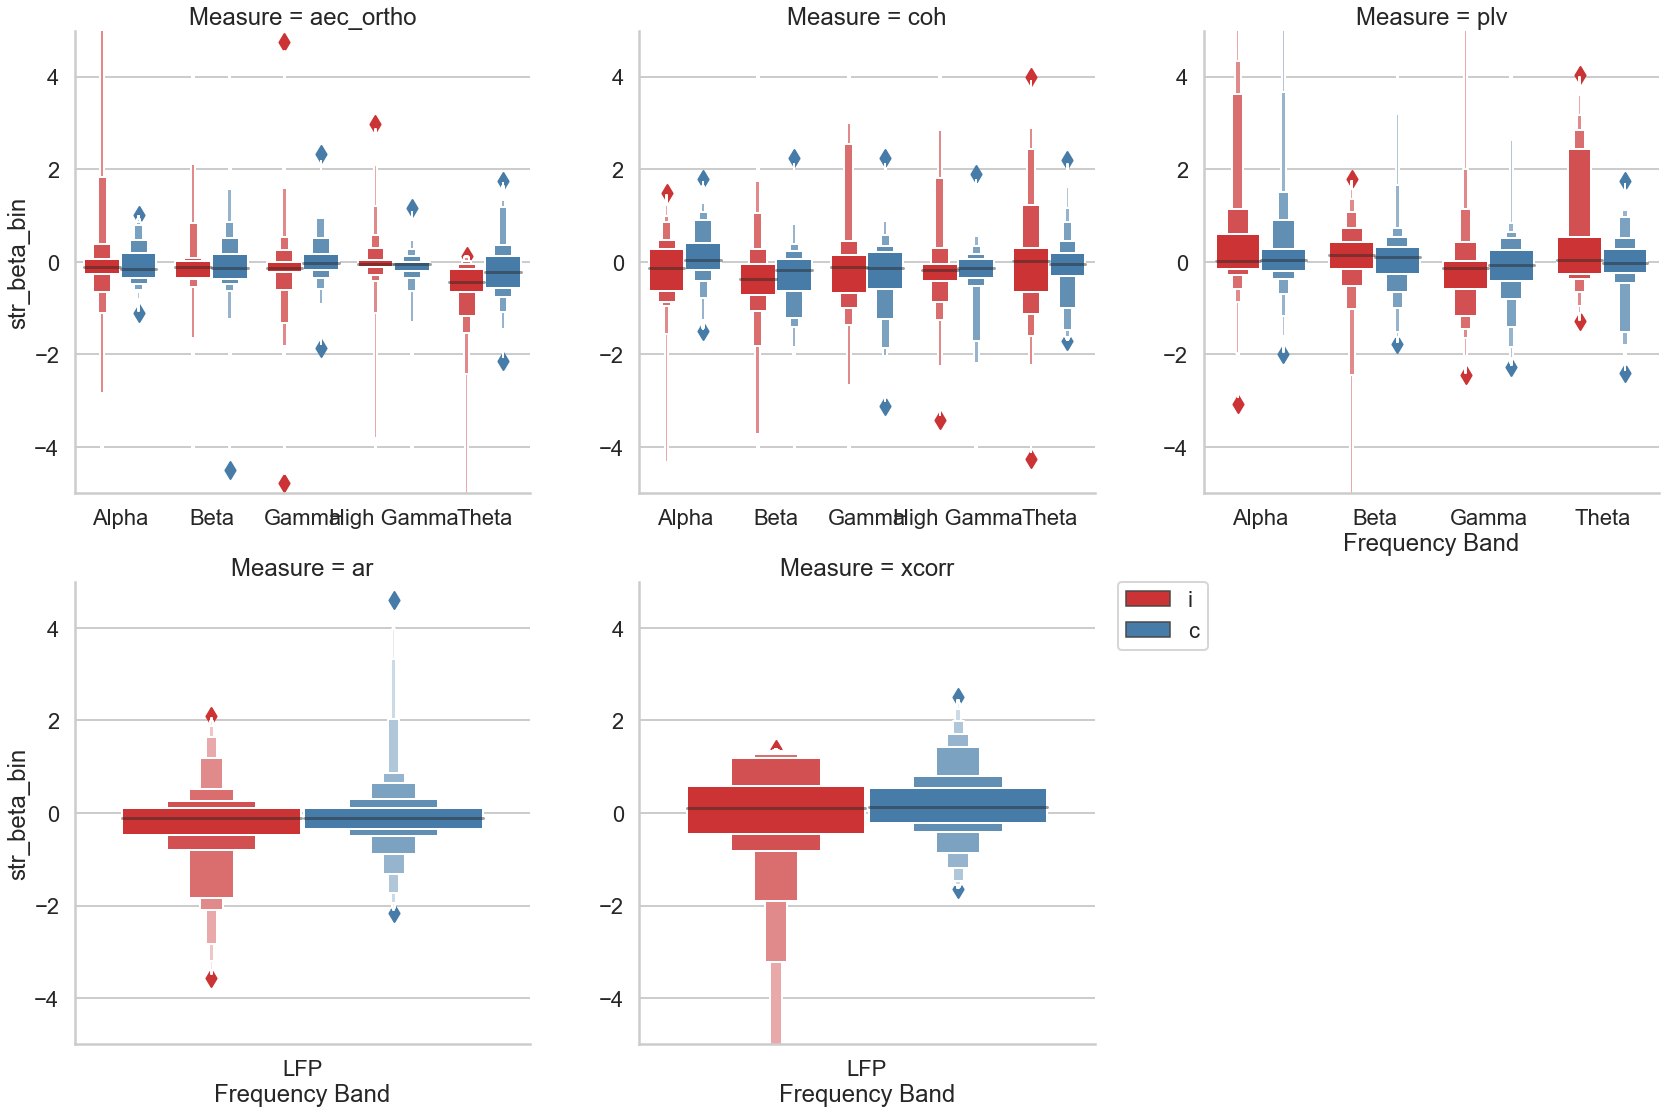

In [51]:
g = sns.FacetGrid(data=net_data[net_data.Measure != 'aec'], col='Measure' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_bin', 'hem_hand', palette = 'Set1', 
      hue_order = ['i', 'c'])
g.axes[4].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.set_ylim(-5,5)
    


In [52]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [142]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

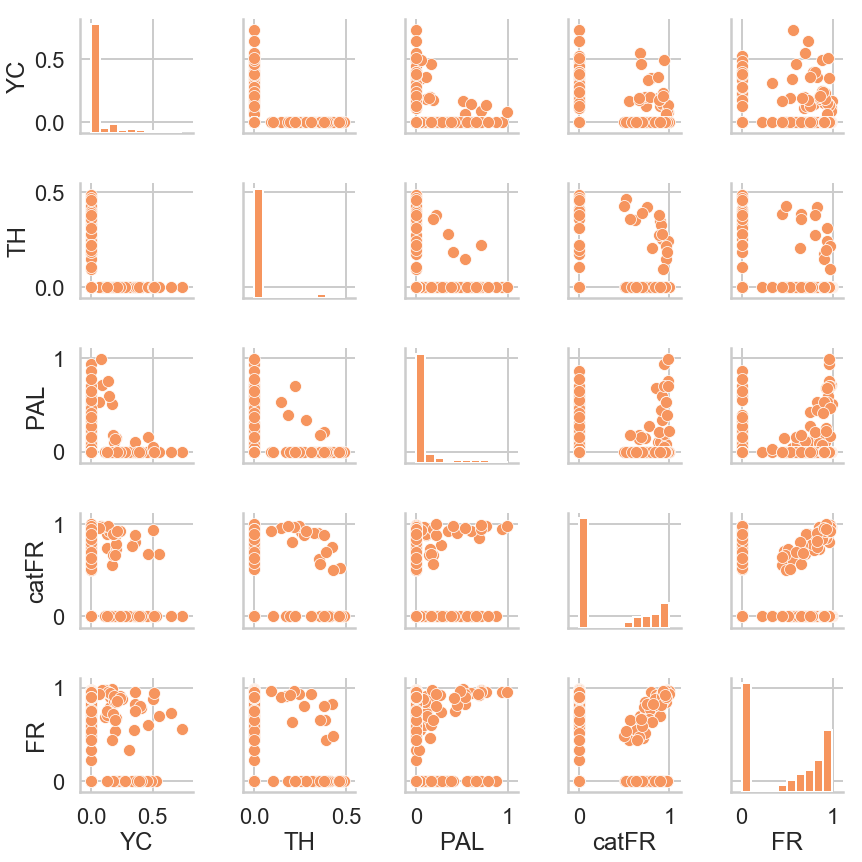

In [143]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [144]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(scale_nav =  1 - task_data['nav'])
task_data = task_data.assign(avg = task_data[['scale_nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

   scale_nav       avg  
0   0.654474  0.474223  
1        NaN  0.719096  
2        NaN  0.343264  
3        NaN  0.625000  
4   0.598222  0.688817

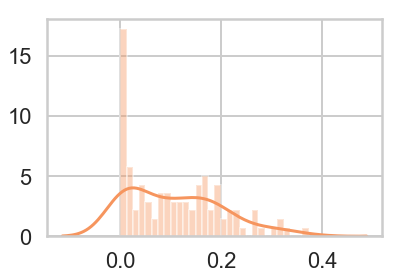

In [145]:
# Are subjects variable across tasks? 
var = pd.core.nanops.nanvar(task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']], axis=1)
var = var[task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']].isna().sum(axis=1) <= 3]
sns.distplot(var, bins=30)

In [146]:
# only keep subjects who completed at least 3
task_data = task_data[task_data[['TH', 'YC', 'PAL','FR', 'catFR']].isna().sum(axis=1) <= 3]
task_data.subj.nunique()

111

In [147]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_task_data = pd.merge(net_data, task_data, on=['subj'])
net_task_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 0 to 1595
Data columns (total 36 columns):
band_measure              1596 non-null object
n_tp                      1596 non-null int64
str_beta_bin              1575 non-null float64
str_beta_num              1575 non-null float64
str_soz_beta_bin          1302 non-null float64
str_soz_beta_num          1302 non-null float64
str_not_soz_beta_num      1296 non-null float64
str_spike_beta_num        1197 non-null float64
str_not_soz_beta_bin      1296 non-null float64
str_spike_beta_bin        1197 non-null float64
str_not_spike_beta_bin    1191 non-null float64
Measure                   1596 non-null object
str_not_spike_beta_num    1191 non-null float64
Frequency Band            1596 non-null object
subj                      1596 non-null object
hand                      1596 non-null object
age                       1596 non-null float64
gender                    1596 non-null object
race                      1596 non-nu

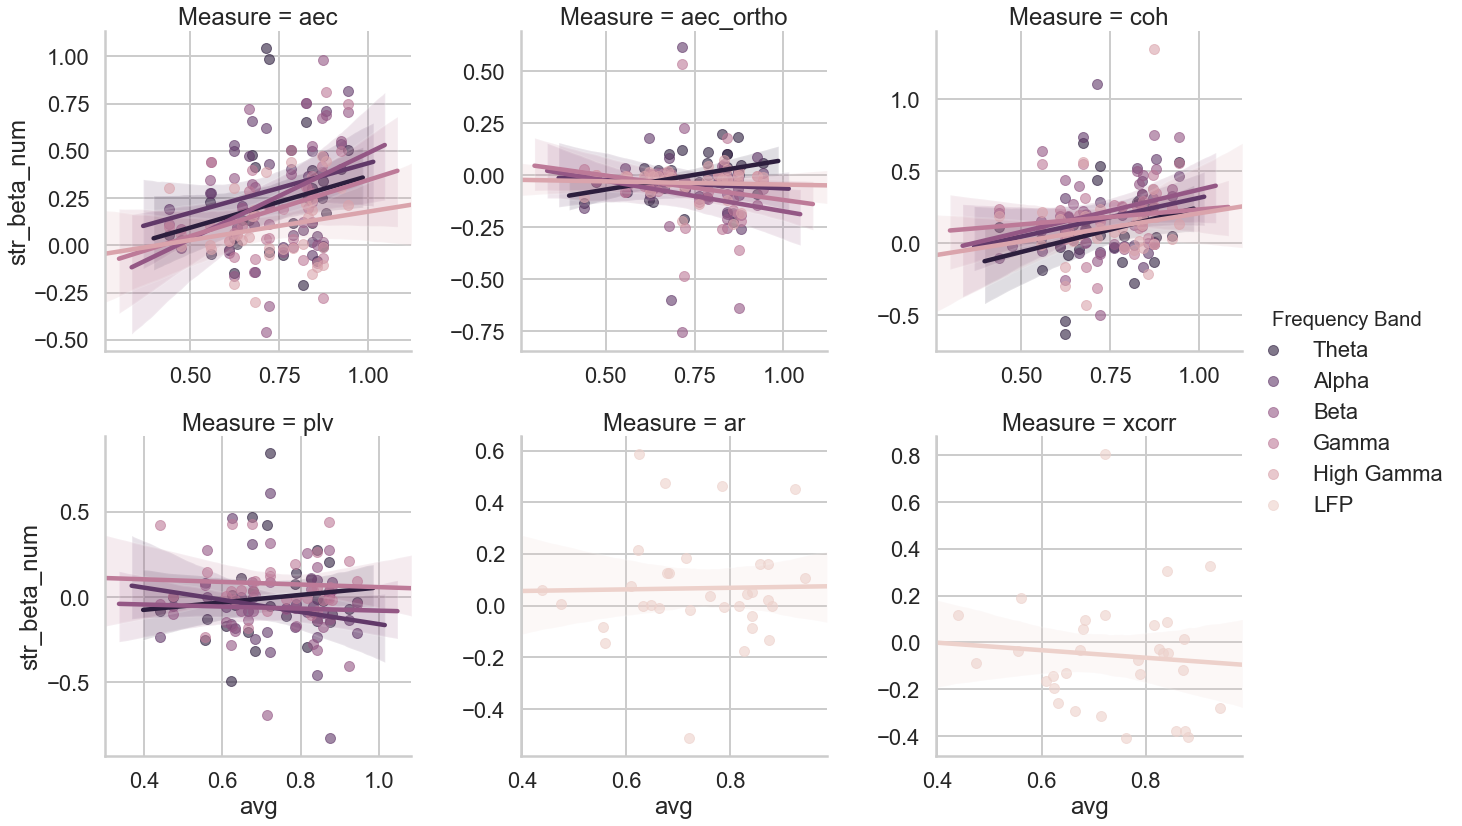

In [130]:
yvar='num'
sns.lmplot(data=net_task_data, x='avg', y='str_beta_' + yvar, hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/avg_behavior_{yvar}{detector}.eps")

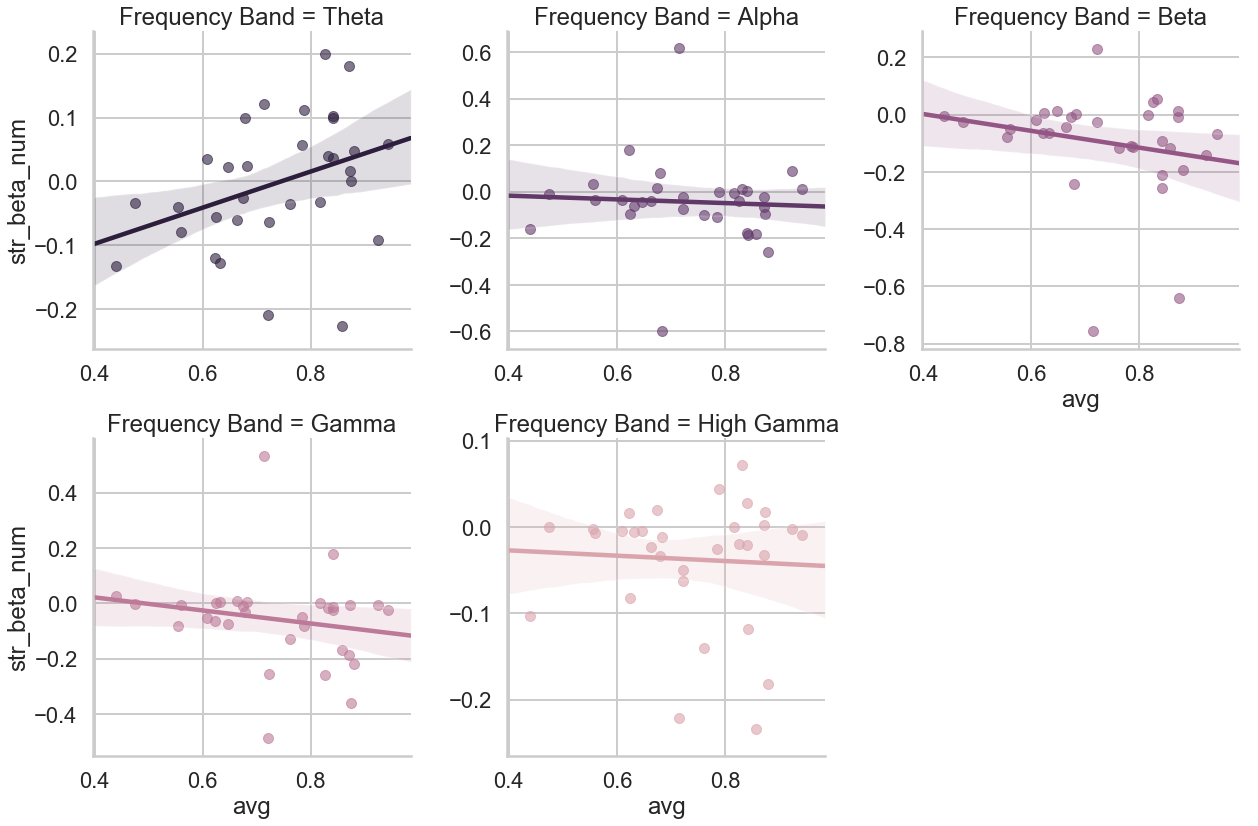

In [131]:
sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'aec_ortho'], x='avg', y='str_beta_num', hue='Frequency Band', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)),
           hue_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           scatter_kws={'s':100, 'alpha':.6}, col_order=['Theta','Alpha','Beta','Gamma','High Gamma'])
plt.savefig(f"../img/task_perf_band{detector}.eps")

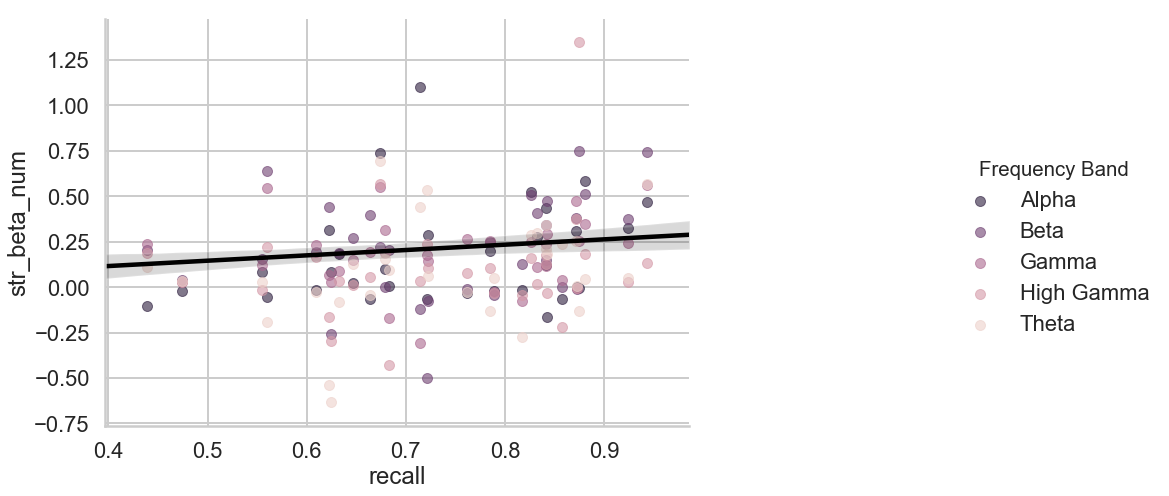

In [124]:
g = sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'coh'], x='avg', y='str_beta_num', hue='Frequency Band', fit_reg=False,
           height=6, sharex=False, sharey=False, palette=sns.color_palette(sns.cubehelix_palette(5, reverse= True)), 
               scatter_kws={'s':100, 'alpha':.6})
sns.regplot(data=net_task_data[net_task_data['Measure'] == 'aec'], x='recall', y='str_beta_num', scatter=False, ax=g.axes[0,0], color='black')
g.fig.set_figwidth(20)
g.fig.set_figheight(8)
plt.savefig(f"../img/task_perf_band{detector}.eps")

In [148]:
# save
net_task_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

In [155]:
# load residual
resid = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/resid{detector}.csv')
resid.head()

Unnamed: 0    subj Measure     resid_num  resid_bin   Band       nav  \
0           1  R1276D     aec -2.612941e-01        NaN  Alpha  0.778258   
1           2  R1260D     aec  4.273061e-02        NaN  Alpha       NaN   
2           3  R1251M     aec  1.182643e-01        NaN  Alpha  0.905021   
3           4  R1250N     aec -1.457168e-16        NaN  Alpha       NaN   
4           5  R1247P     aec -5.081516e-02        NaN  Alpha       NaN   

     recall  
0  0.702573  
1  0.674543  
2  0.943681  
3  0.718227  
4  0.818637

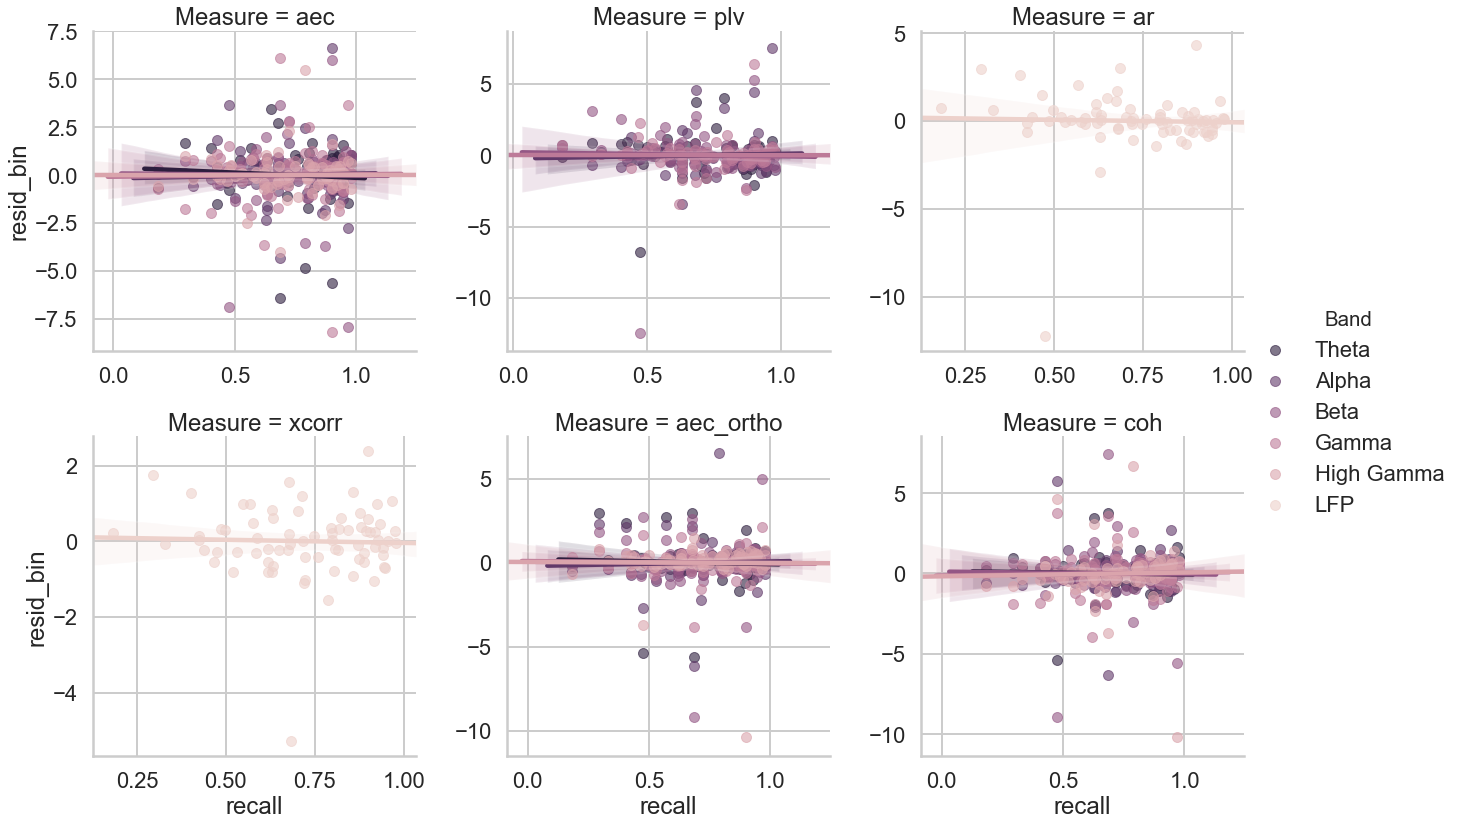

In [159]:
yvar='bin'
t = 'recall'
sns.lmplot(data=resid, x=t, y='resid_' + yvar, hue='Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/{t}_behavior_{yvar}_{detector}.eps")

Other parameters

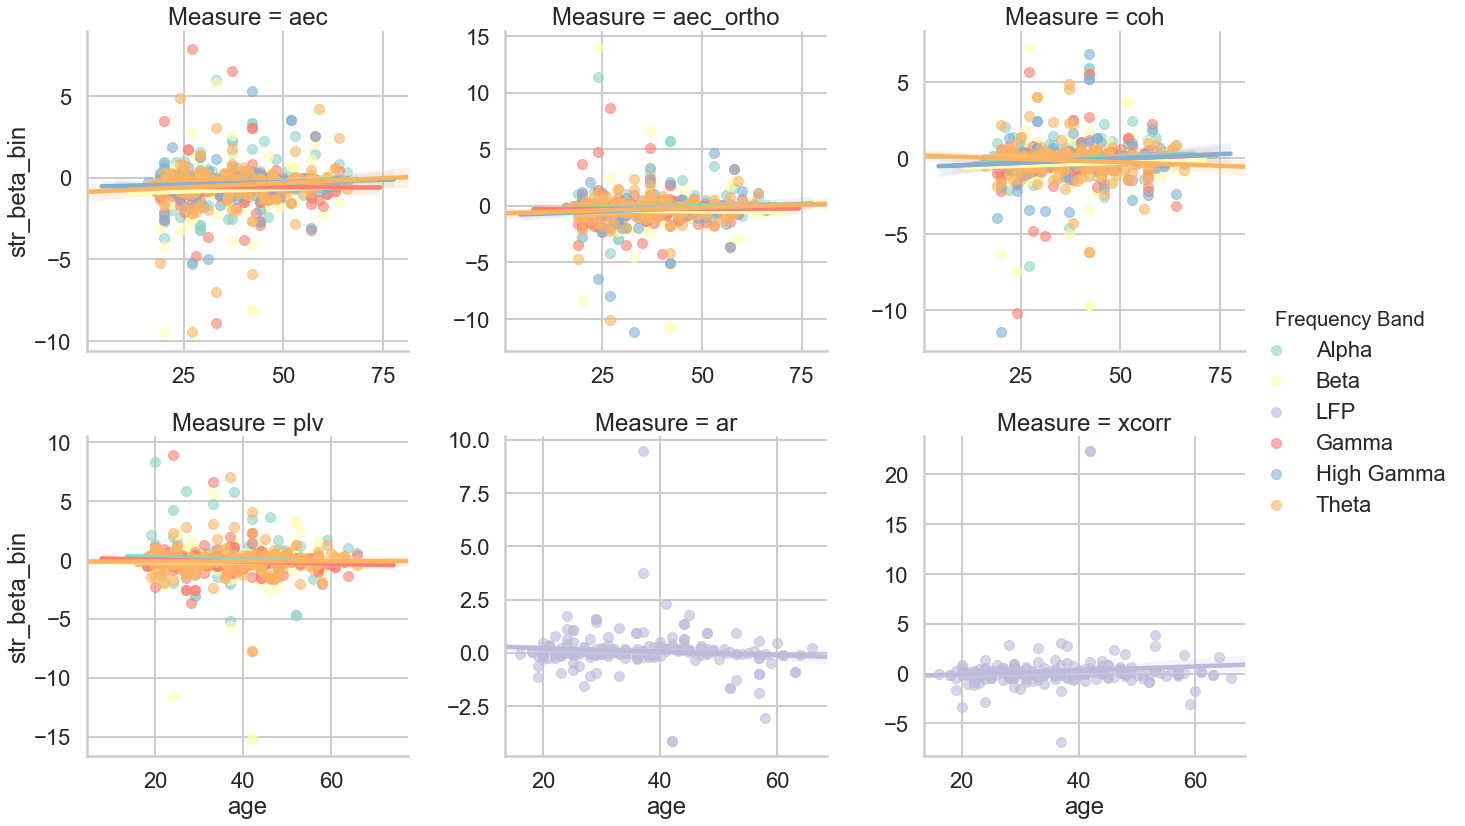

In [214]:
sns.lmplot(data=net_task_data, x='age', y='str_beta_bin', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set3', scatter_kws={'s':100, 'alpha':.6})

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


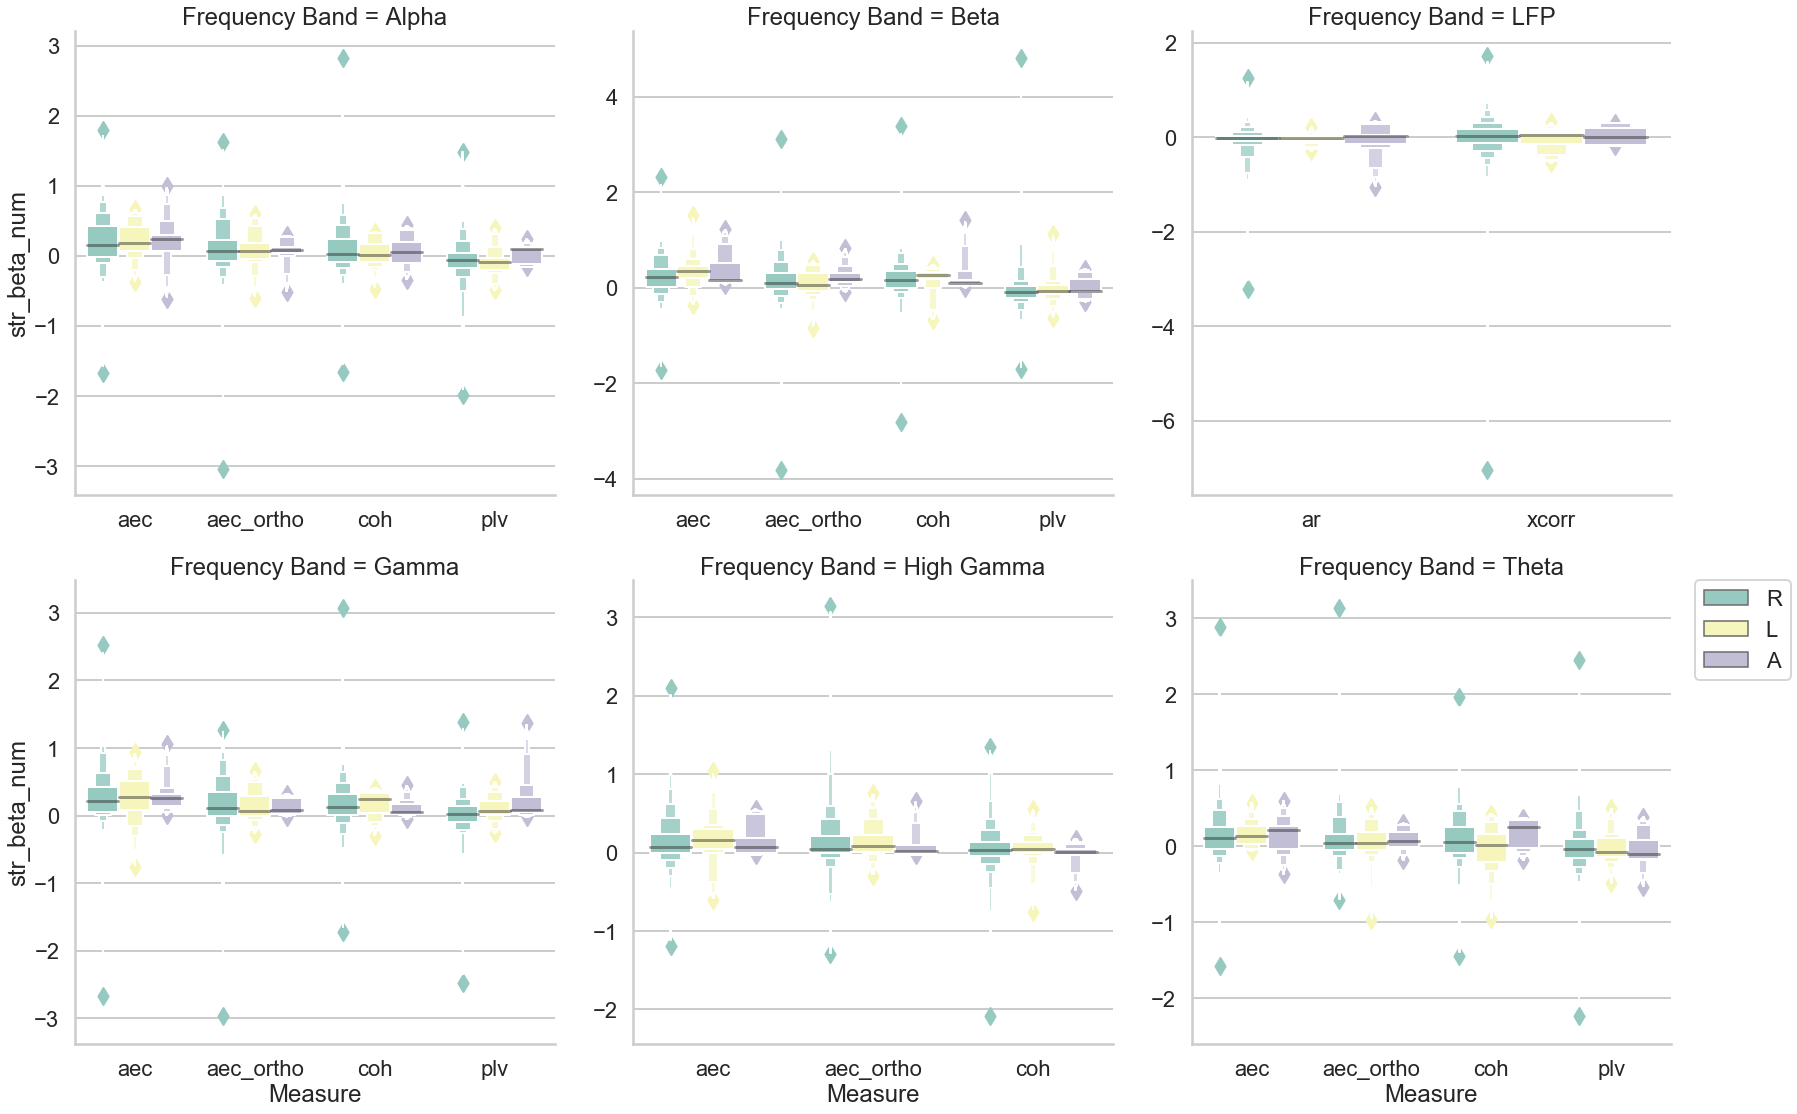

In [215]:
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_num', 'hand', palette = "Set3", hue_order=['R','L', 'A'])
#g.map(sns.stripplot, 'fc_measure', 'spike_beta_num', 'spike',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_spike_beta_num','str_not_spike_beta_num'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)